In [1]:
# ===========================
#  CARGA DE LIBRERÍAS
# ===========================

# NumPy y pandas para manejo de datos
import numpy as np
import pandas as pd

# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

# Estadística y regresión con Statsmodels
from statsmodels.api import OLS, add_constant

# Modelos lineales de Scikit-learn
from sklearn.linear_model import (
    LinearRegression,
    Ridge, Lasso, ElasticNet, LassoLars,
    RidgeCV, LassoCV, ElasticNetCV, LassoLarsCV
)

from group_lasso import GroupLasso

# Utilidades para entrenamiento y evaluación
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV
)
from sklearn.metrics import (
    mean_squared_error, r2_score, make_scorer
)

# Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Pipeline y reducción de dimensionalidad
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Dataset de diabetes
from sklearn.datasets import load_diabetes

# Combinaciones útiles (por ejemplo, selección de variables)
from itertools import combinations

import seaborn as sns


El **Diabetes Dataset** contiene información médica de pacientes y se utiliza para predecir la progresión de la enfermedad de la diabetes un año después de la recolección de los datos basales.

Tamaño del conjunto de datos:
- N° de muestras: 442 pacientes
- N° de predictores: 10 variables numéricas continuas

El conjunto de datos ha sido estandarizado (media 0, varianza 1). Los predictores son:
- Edad (age)
- Sexo (sex)
- Índice de masa corporal (BMI)
- Presión arterial media (bp)
- Seis medidas bioquímicas en sangre (s1 a s6)

In [2]:
# Cargar el dataset de Diabetes
diabetes = load_diabetes()

# Crear un DataFrame con los datos
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Agregar la columna de etiquetas (progresión de la diabetes)
df_diabetes['Progression'] = diabetes.target

# Mostrar las primeras filas
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [3]:
np.isnan(df_diabetes['Progression']).sum()

0

### División del DataSet Diabetes

El conjunto de datos, generalmente, se divide en tres muestras no superpuestas: 

- **Muestra de entrenamiento** utilizada para entrenar el modelo. 
- **Muestra de validación** utilizada para validar y ajustar el modelo. 
- **Muestra de prueba** utilizada para probar la capacidad predictiva del modelo en nuevos datos. 

In [4]:
# Preparar los datos
y = np.array(df_diabetes['Progression'])
X = df_diabetes.drop('Progression', axis=1)  # Mantén X como un DataFrame


#Dividir en entrenamiento, validación y prueba
pct_val = 0.20
pct_test = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=pct_test, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=pct_val/(1-pct_test), random_state=100)

### Elección del modelo óptimo

##### Cp de Mallows

In [5]:
# Modelo reducido: usaremos solo las primeras 4 variables como ejemplo
selected_features = ['age', 'sex', 'bmi', 'bp']

# Función para calcular Cp de Mallows
def Cp(X_train, y_train, selected_features):
    n = len(y_train)

    # Modelo completo para estimar sigma^2
    X_train_full = add_constant(X_train)
    model_full = OLS(y_train, X_train_full).fit()
    sigma2_hat = model_full.scale

    # Modelo reducido con las variables seleccionadas
    X_train_reduced = add_constant(X_train[selected_features])
    model_reduced = OLS(y_train, X_train_reduced).fit()
    rss_reduced = np.sum(model_reduced.resid ** 2)
    d_reduced = len(model_reduced.params)

    # Cálculo de Cp de Mallows
    Cp = (rss_reduced + 2 * d_reduced * sigma2_hat) / n
    return Cp

# Alternativa equivalente para calcular Cp (fórmula diferente)
def Cp_alternativa(X_train, y_train, selected_features):
    n = len(y_train)

    # Modelo completo para estimar sigma^2
    X_train_full = add_constant(X_train)
    model_full = OLS(y_train, X_train_full).fit()
    sigma2_hat = model_full.scale

    # Modelo reducido con las variables seleccionadas
    X_train_reduced = add_constant(X_train[selected_features])
    model_reduced = OLS(y_train, X_train_reduced).fit()
    rss_reduced = np.sum(model_reduced.resid ** 2)
    d_reduced = len(model_reduced.params)

    # Cálculo alternativo de Cp
    Cp_alt = (rss_reduced / sigma2_hat) - (n - 2 * d_reduced)
    return Cp_alt

# Resultados
print(f"Cp de Mallows del modelo reducido:             {Cp(X_train, y_train, selected_features):.4f}")
print(f"Cp_alternativa de Mallows del modelo reducido: {Cp_alternativa(X_train, y_train, selected_features):.4f}")


Cp de Mallows del modelo reducido:             3712.2905
Cp_alternativa de Mallows del modelo reducido: 75.6615


**add_constant()** agrega una columna de unos al inicio de la matriz de predictores. Esa columna representa el término independiente (intercepto) del modelo de regresión. Es necesario porque statsmodels.OLS no incluye automáticamente un intercepto, a diferencia de scikit-learn. Por eso hay que agregarlo manualmente si queremos que el modelo tenga un término constante. 

##### AIC, BIC y $R^{2}$ ajustado

Lo podemos calcular de manera manual utilizando la fórmula de aproximación para modelos lineales de AIC/BIC o utilizar statsmodels, ya que tiene incluido el calculo de AIC/BIC utilizando la verosimilitud del modelo reducido. 

In [6]:
def aic_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params) - 1                     # número de parámetros
    rss = np.sum(model.resid ** 2)

    # AIC: AIC = (RSS + 2 * d * sigma^2) / n
    sigma2_hat = rss / (n - d)
    aic_manual = (rss + 2 * d * sigma2_hat) / n

    return aic_manual

def bic_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params) - 1                   # número de parámetros
    rss = np.sum(model.resid ** 2)

    # BIC: BIC = (RSS + log(n) * d * sigma^2) / n
    sigma2_hat = rss / (n - d)
    bic_manual = (rss + np.log(n) * d * sigma2_hat) / n

    return bic_manual


def r2_adj_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params) - 1                   # número de parámetros, ya que model.params incluye el intercepto
    y_mean = np.mean(y_train)
    rss = np.sum(model.resid ** 2)
    tss = np.sum((y_train - y_mean)**2)

    # R² ajustado: R2_adj = 1 - (RSS / (n - d - 1)) / (TSS / (n - 1))
    r2_adj_manual = 1 - (rss / (n - d - 1)) / (tss / (n - 1))

    return r2_adj_manual


# --- Comparación con statsmodels ---
X_train_red = add_constant(X_train[selected_features])
model = OLS(y_train, X_train_red).fit()
aic = model.aic
bic = model.bic
r2_adj = model.rsquared_adj

# Mostrar resultados
print("--------- Cálculos Manuales ---------")
print(f"AIC manual:              {aic_manual(X_train, y_train, selected_features):.4f}")
print(f"BIC manual:              {bic_manual(X_train, y_train, selected_features):.4f}")
print(f"R² ajustado (manual):    {r2_adj_manual(X_train, y_train, selected_features):.4f}")

print("\n----------- Statsmodels -------------")
print(f"AIC (statsmodels):       {aic:.4f}")
print(f"BIC (statsmodels):       {bic:.4f}")
print(f"R² ajustado (stats):     {r2_adj:.4f}")


--------- Cálculos Manuales ---------
AIC manual:              3710.6766
BIC manual:              3888.1278
R² ajustado (manual):    0.3734

----------- Statsmodels -------------
AIC (statsmodels):       3407.5083
BIC (statsmodels):       3426.1588
R² ajustado (stats):     0.3734


### Validación y validación cruzada

##### Validación

In [7]:
# Función para calcular el error cuadrático medio (MSE) en un conjunto de validación
def validación(X_train, y_train, X_val, y_val, selected_features):
    # Ajustar modelo con las variables seleccionadas
    X_train_red = add_constant(X_train[selected_features])
    model = OLS(y_train, X_train_red).fit()
    
    # Preparar datos de validación
    X_val_reduced = add_constant(X_val[selected_features])
    
    # Predecir sobre el conjunto de validación
    y_val_pred = model.predict(X_val_reduced)
    
    # Calcular MSE
    MSE = mean_squared_error(y_val, y_val_pred)
    return MSE

# Mostrar resultado
print(f"MSE de validación: {validación(X_train, y_train, X_val, y_val, selected_features):.2f}")

# Función para calcular el error cuadrático medio (MSE) en un conjunto de validación
def validacion(modelo, X_val, y_val, selected_features):

    # Preparar datos de validación
    X_val_reduced = add_constant(X_val[selected_features])
    
    # Predecir sobre el conjunto de validación
    y_val_pred = modelo.predict(X_val_reduced)
    
    # Calcular MSE
    MSE = mean_squared_error(y_val, y_val_pred)
    return MSE


MSE de validación: 3525.98


##### Validación Cruzada

In [8]:
# Función para realizar validación cruzada k-fold con OLS
def validacion_cruzada(X, y, selected_features, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=100)  # Crea los pliegues con aleatorización
    mse_scores = []                       # Guarda el MSE de cada fold
    best_mse = float('inf')               # Inicializa el mejor MSE
    best_model = None                     # Para guardar el mejor modelo

    for train_index, val_index in kf.split(X):
        # Separar conjuntos de entrenamiento y validación para este fold
        X_ktrain, X_kval = X.iloc[train_index], X.iloc[val_index]
        y_ktrain, y_kval = y[train_index], y[val_index]

        # Añadir la constante (intercepto) y seleccionar variables
        X_ktrain_red = add_constant(X_ktrain[selected_features])
        X_kval_red = add_constant(X_kval[selected_features])

        # Ajustar modelo OLS
        model_k = OLS(y_ktrain, X_ktrain_red).fit()

        # Predecir y calcular MSE en validación
        y_pred_k = model_k.predict(X_kval_red)
        mse_k = mean_squared_error(y_kval, y_pred_k)
        mse_scores.append(mse_k)

        # Si este modelo es mejor, guardarlo
        if mse_k < best_mse:
            best_mse = mse_k
            best_model = model_k

    return best_model, best_mse, mse_scores

k=5
vc=validacion_cruzada(X_train, y_train, selected_features, k=5)

print("\n===== Validación cruzada ({}-fold) =====".format(k))
print("MSE por fold:", np.round(vc[2], 2))
print(f"MSE medio (CV): {np.mean(vc[2]):.4f}")

print("\n===== Mejor modelo =====")
print(f"Mejor MSE: {vc[1]:.4f}")
print("Coeficientes del mejor modelo:")
print(vc[0].summary())


===== Validación cruzada (5-fold) =====
MSE por fold: [3663.31 3865.04 4354.6  2879.65 4120.75]
MSE medio (CV): 3776.6708

===== Mejor modelo =====
Mejor MSE: 2879.6455
Coeficientes del mejor modelo:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     35.79
Date:                Wed, 21 May 2025   Prob (F-statistic):           1.75e-23
Time:                        18:47:29   Log-Likelihood:                -1368.8
No. Observations:                 247   AIC:                             2748.
Df Residuals:                     242   BIC:                             2765.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
         

# Selección de subconjuntos

Aquí vamos a implementar los métodos que reducen el número de parámetros en un modelo restringuiendo el modelo a un subconjunto de los predictores. 

### Selección del mejor subconjunto

Basado en el **Algoritmo 3.1**

In [9]:
def mejor_subconjunto(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):
    # p es el número de características (predictores) en el conjunto de datos
    p = X.shape[1]
    n = len(y)  # n es el número de observaciones
    predictores = X.columns  # Obtiene los nombres de las características (columnas de X)
    resultados_por_k = []  # Lista para almacenar los resultados de cada k

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale  # Estima sigma^2, el error cuadrático medio

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo que predice la media de y
    resultados_por_k.append({
        'k': 0,  # Modelo nulo tiene 0 predictores
        'modelo': modelo_nulo,
        'predictores': []
    })
    
    # Iterar sobre diferentes valores de k (número de predictores)
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_comb = None  # Inicializa la mejor combinación de predictores

        # Genera todas las combinaciones posibles de k predictores
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])  # Agrega la constante a la combinación de predictores
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS con estos predictores
            r2 = modelo.rsquared  # Obtiene el R² del modelo

            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        # Almacena los resultados de este k en la lista
        resultados_por_k.append({
            'k': k,  # Número de predictores
            'modelo': mejor_modelo_k,  # Mejor modelo encontrado
            'predictores': mejor_comb,  # Mejor combinación de predictores
        })

    metricas = []  # Lista para almacenar las métricas de cada modelo
    mejores_modelos_cv = []  # Lista para almacenar los mejores modelos según validación cruzada

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según el criterio Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            metricas.append(validacion(modelo, X_val, y_val, list(res['predictores'])))

        # Selección según validación cruzada
        elif criterio == 'cv':
            best_model_k, best_mse_k, mse_scores_k = validacion_cruzada(X_train, y_train, list(res['predictores']), k_cv )
            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica

Es el algoritmo 3.1, pero añadiendole que me calcule algunas cosas adicionales para utilizarlo para graficar posteriormente. 

In [10]:
def Mejor_Subconjunto(X, y, criterio=None, X_val=None, y_val=None, k_cv=5, verbose=True):
    # Número de predictores y observaciones
    p = X.shape[1]
    n = len(y)
    predictores = X.columns
    resultados_por_k = []

    # Modelo completo (todos los predictores)
    X_full = add_constant(X)
    modelo_full = OLS(y, X_full).fit()
    sigma2_hat = modelo_full.scale  # Varianza estimada del error, se usa en Cp

    # Modelo nulo (solo intercepto)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()
    resultados_por_k.append({'k': 0, 'modelo': modelo_nulo, 'predictores': []})

    # Inicialización de listas para análisis y gráficas
    num_predictores = []   # Número de predictores por cada modelo probado
    rss_todos = []         # RSS de todos los modelos evaluados
    r2_todos = []          # R2 de todos los modelos evaluados
    rss_mejores = []       # RSS del mejor modelo para cada k
    r2_mejores = []        # R2 del mejor modelo para cada k
    k_values = []          # Valores de k correspondientes a los mejores modelos

    # Búsqueda exhaustiva: probar todas las combinaciones de tamaño k
    for k in range(1, p + 1):
        mejor_rss = np.inf
        mejor_r2 = -np.inf
        mejor_modelo_k = None
        mejor_comb = None

        # Probar todas las combinaciones posibles de k predictores
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])
            modelo = OLS(y, X_k).fit()
            rss = np.sum(modelo.resid ** 2)
            r2 = modelo.rsquared

            # Registrar cada combinación para gráficas
            num_predictores.append(k)
            rss_todos.append(rss)
            r2_todos.append(r2)

            # Verificar si es el mejor modelo para ese k
            if rss < mejor_rss:
                mejor_rss = rss
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        # Guardar mejor modelo para este k
        resultados_por_k.append({'k': k, 'modelo': mejor_modelo_k, 'predictores': mejor_comb})
        rss_mejores.append(mejor_rss)
        r2_mejores.append(mejor_r2)
        k_values.append(k)

    # Crear DataFrame con métricas para cada modelo (por mejor k)
    resultados_df = pd.DataFrame({
        'k': [res['k'] for res in resultados_por_k],
        'Cp': np.nan,
        'AIC': np.nan,
        'BIC': np.nan,
        'R2_adj': np.nan,
        'Validacion': np.nan,
        'CV': np.nan
    })

    # Calcular métricas para cada modelo guardado
    for i, res in enumerate(resultados_por_k):
        modelo = res['modelo']
        k = res['k']

        # Omitir modelo nulo
        if k == 0:
            continue

        pred = list(res['predictores'])
        X_k = add_constant(X[pred])
        modelo_k = OLS(y, X_k).fit()
        rss = np.sum(modelo_k.resid ** 2)

        # Cp de Mallows
        cp = (rss + 2 * k * sigma2_hat) / n
        resultados_df.loc[i, 'Cp'] = cp

        # Métricas clásicas
        resultados_df.loc[i, 'AIC'] = modelo_k.aic
        resultados_df.loc[i, 'BIC'] = modelo_k.bic
        resultados_df.loc[i, 'R2_adj'] = modelo_k.rsquared_adj

        # Validación externa si se proveen datos
        if X_val is not None and y_val is not None:
            val_error = validacion(modelo_k, X_val, y_val, pred)
            resultados_df.loc[i, 'Validacion'] = val_error

        # Validación cruzada
        _, cv_mse, _ = validacion_cruzada(X, y, pred, k_cv)
        resultados_df.loc[i, 'CV'] = cv_mse

    # Determinar criterios a evaluar
    criterios_validos = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']
    if criterio is None or criterio == 'todos':
        criterios_a_evaluar = criterios_validos
    elif criterio in criterios_validos:
        criterios_a_evaluar = [criterio]
    else:
        raise ValueError(f"Criterio inválido: {criterio}. Debe ser uno de {criterios_validos} o None/'todos'.")

    mejores_modelos = {}

    # Seleccionar el mejor modelo por cada criterio
    for crit in criterios_a_evaluar:
        if crit == 'R2_adj':
            idx_mejor = resultados_df[crit].idxmax()  # Maximizar R2 ajustado
        else:
            idx_mejor = resultados_df[crit].idxmin()  # Minimizar los demás

        mejor_modelo = resultados_por_k[idx_mejor]
        mejores_modelos[crit] = {
            'k': mejor_modelo['k'],
            'predictores': mejor_modelo['predictores'],
            'metrica': resultados_df.loc[idx_mejor, crit],
            'modelo': mejor_modelo['modelo']
        }

        # Mostrar resultados si verbose=True
        if verbose:
            print(f"\n========= Mejor modelo según {crit} =========")
            print(f"  k = {mejor_modelo['k']}")
            print(f"  Predictores: {mejor_modelo['predictores']}")
            print(f"  Métrica ({crit}): {resultados_df.loc[idx_mejor, crit]:.4f}")
            print(mejor_modelo['modelo'].summary())

    # Datos para graficar evolución de modelos
    graficos_data = {
        'num_predictores': num_predictores,  # todos los modelos probados
        'rss_todos': rss_todos,
        'r2_todos': r2_todos,
        'rss_mejores': rss_mejores,          # solo los mejores por k
        'r2_mejores': r2_mejores,
        'k_values': k_values
    }

    return resultados_df, graficos_data, mejores_modelos

In [11]:
resultados_df, graficos, mejores = Mejor_Subconjunto(X_train, y_train, criterio=None, X_val=X_val, y_val=y_val)


========= Mejor modelo según Cp =========
  k = 6
  Predictores: ('sex', 'bmi', 'bp', 's1', 's4', 's5')
  Métrica (Cp): 3017.2779
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Wed, 21 May 2025   Prob (F-statistic):           4.70e-43
Time:                        18:47:34   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [12]:
resumen = pd.DataFrame([
    {
        'Criterio': crit,            
        'k': info['k'],
        'Predictores': ', '.join(info['predictores'])
    }
for crit, info in mejores.items()
])

print("\nResumen de los mejores modelos por criterio:")
resumen


Resumen de los mejores modelos por criterio:


,Criterio,k,Predictores
0,Cp,6,"sex, bmi, bp, s1, s4, s5"
1,AIC,6,"sex, bmi, bp, s1, s4, s5"
2,BIC,5,"sex, bmi, bp, s3, s5"
3,R2_adj,7,"sex, bmi, bp, s1, s2, s4, s5"
4,Validacion,7,"sex, bmi, bp, s1, s2, s4, s5"
5,CV,4,"bmi, bp, s3, s5"


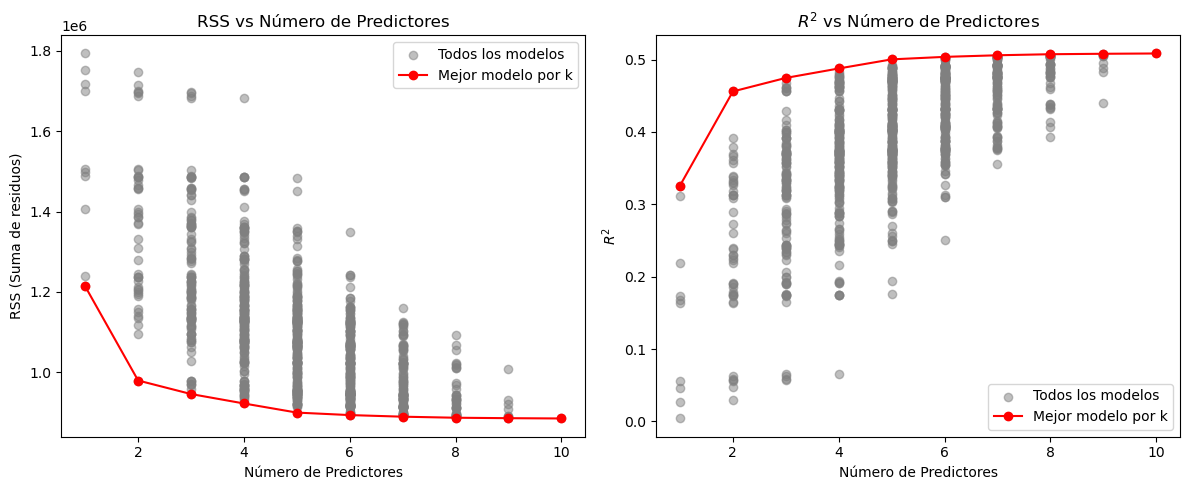

In [13]:
# Crear una figura con dos subplots lado a lado (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# === Gráfica RSS vs Número de Predictores ===
axes[0].scatter(
    # Puntos: número de predictores vs RSS de todos los modelos evaluados
    graficos['num_predictores'], graficos['rss_todos'],
    color='gray', alpha=0.5, label='Todos los modelos'  # Puntos grises semi-transparentes
)
axes[0].plot(
    # Línea roja con círculos: RSS del mejor modelo para cada cantidad de predictores k
    graficos['k_values'], graficos['rss_mejores'],
    '-o', color='red', label='Mejor modelo por k'
)
axes[0].set_xlabel('Número de Predictores')     # Etiqueta eje X
axes[0].set_ylabel('RSS (Suma de residuos)')    # Etiqueta eje Y
axes[0].set_title('RSS vs Número de Predictores')  # Título del subplot
axes[0].legend()  # Mostrar leyenda

# === Gráfica R² vs Número de Predictores ===
axes[1].scatter(
    # Puntos: número de predictores vs R² de todos los modelos evaluados
    graficos['num_predictores'], graficos['r2_todos'],
    color='gray', alpha=0.5, label='Todos los modelos'  # Puntos grises semi-transparentes
)
axes[1].plot(
    # Línea roja con círculos: R² del mejor modelo para cada cantidad de predictores k
    graficos['k_values'], graficos['r2_mejores'],
    '-o', color='red', label='Mejor modelo por k'
)
axes[1].set_xlabel('Número de Predictores')  # Etiqueta eje X
axes[1].set_ylabel('$R^2$')                  # Etiqueta eje Y (notación matemática)
axes[1].set_title('$R^2$ vs Número de Predictores')  # Título del subplot
axes[1].legend()  # Mostrar leyenda

# Ajustar el layout para que no se monten los elementos y se vean bien
plt.tight_layout()

# Mostrar la figura con ambos gráficos
plt.show()



Figura 6.2 6.3

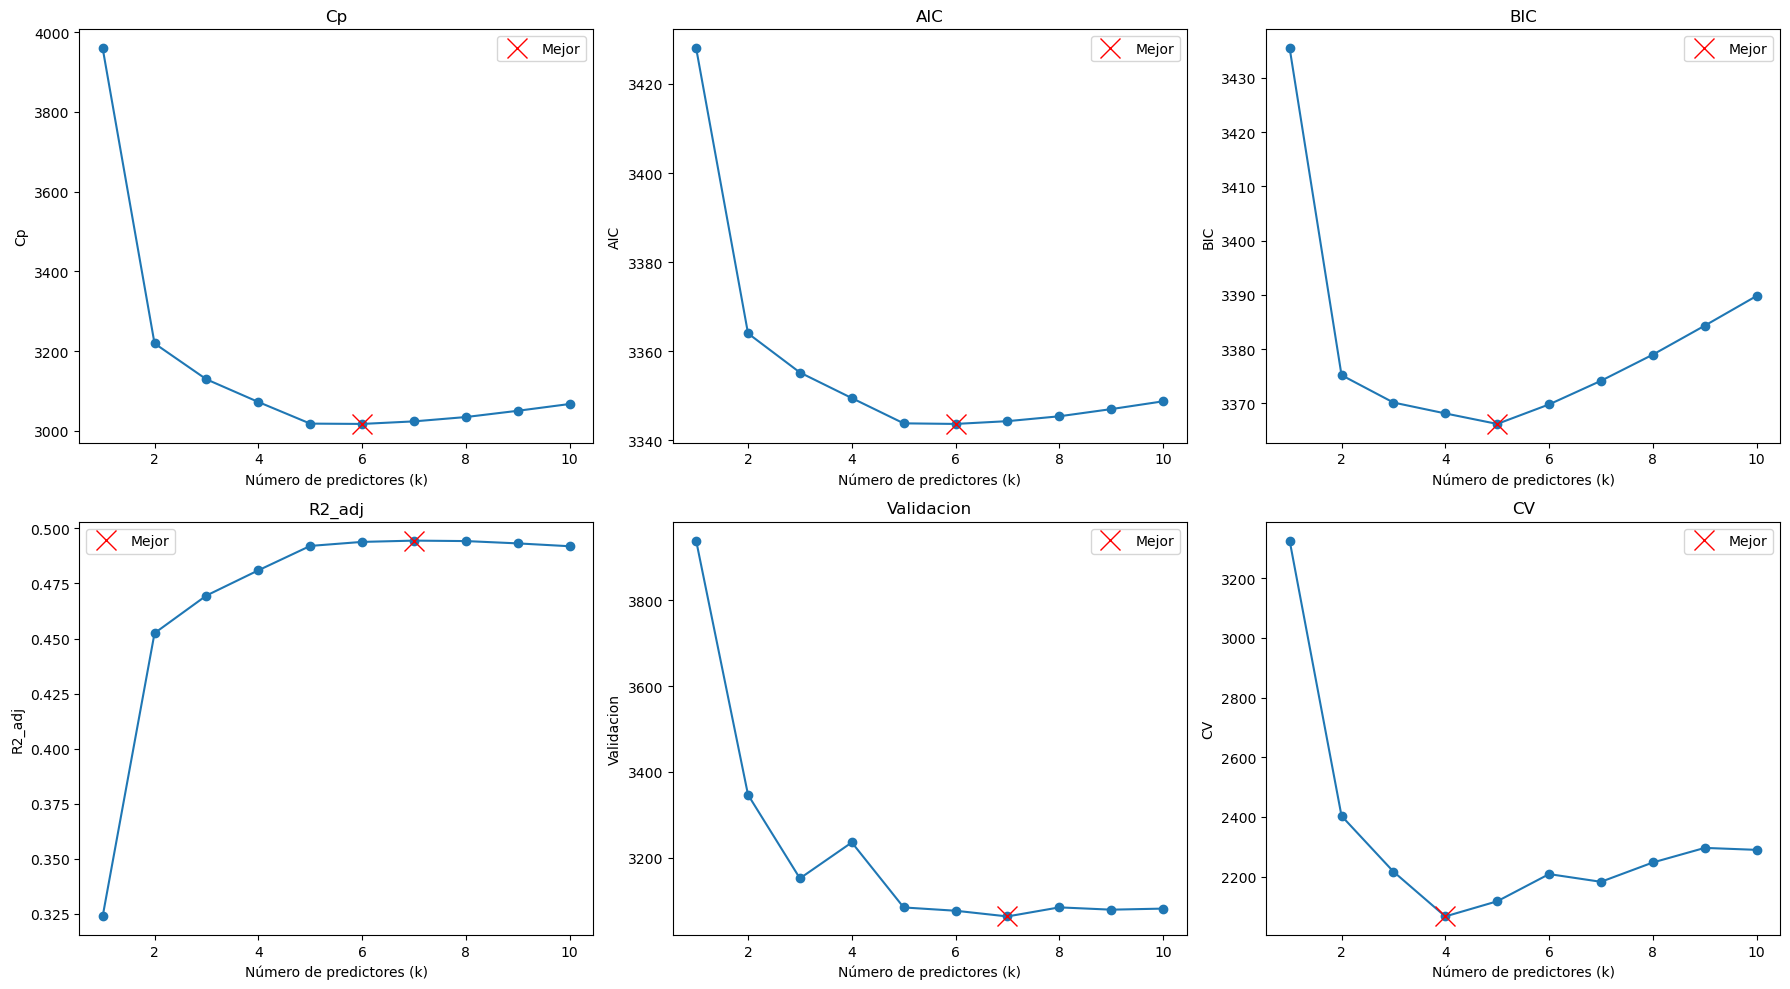

In [14]:
# Lista de criterios que vamos a graficar (deben coincidir con los nombres de las columnas del DataFrame resultados_df)
criterios = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']

# Crear una figura con una grilla de 2 filas y 3 columnas para los subplots, tamaño grande para mejor visualización
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
# Aplanar la matriz de ejes para acceder fácilmente con un índice simple en el loop
axs = axs.ravel()

# Loop para graficar cada criterio en un subplot diferente
for i, criterio in enumerate(criterios):
    # Extraer las columnas 'k' y el criterio actual, eliminando filas con valores NaN para evitar errores
    data = resultados_df[['k', criterio]].dropna()

    # Graficar el criterio vs número de predictores (k) con línea y puntos marcadores circulares
    axs[i].plot(data['k'], data[criterio], marker='o', linestyle='-')

    # Encontrar el índice del mejor valor para marcarlo (máximo para R2_adj, mínimo para los demás)
    if criterio == 'R2_adj':
        best_idx = data[criterio].idxmax()
    else:
        best_idx = data[criterio].idxmin()

    # Obtener el número de predictores (k) y el valor del criterio para el mejor modelo
    best_k = data.loc[best_idx, 'k']
    best_val = data.loc[best_idx, criterio]

    # Marcar el mejor punto con una 'x' roja grande para destacarlo
    axs[i].plot(best_k, best_val, 'x', markersize=15, label='Mejor', color='red')

    # Añadir título al subplot con el nombre del criterio
    axs[i].set_title(criterio)

    # Etiquetas de los ejes
    axs[i].set_xlabel('Número de predictores (k)')
    axs[i].set_ylabel(criterio)

    # Mostrar leyenda para identificar el mejor punto marcado
    axs[i].legend()

# Ajustar el layout para que no se monten los gráficos y las etiquetas se vean bien
plt.tight_layout()

# Mostrar la figura con todos los subplots
plt.show()


### Forward Stepwise Selection

Basado en el **Algortimo 3.2**

In [15]:
def forward_stepwise_selection(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # Número de predictores
    n = len(y)  # Número de observaciones
    predictores = X.columns  # Nombres de las columnas de X
    predictores_restantes = set(predictores)  # Inicializa un conjunto con todos los predictores
    resultados_por_k = []  # Almacena los modelos seleccionados en cada paso

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale  # Estima sigma^2, el error cuadrático medio

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo que predice la media de y
    resultados_por_k.append({
        'k': 0,  # El modelo nulo tiene 0 predictores
        'modelo': modelo_nulo,
        'predictores': []
    })

    # Iterar sobre el número de predictores, desde 1 hasta p
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_predictores = None  # Inicializa la mejor combinación de predictores
        predictores_a_agregar = []  # Lista de predictores a agregar en cada paso
        
        # Evaluar todos los modelos que agregan un predictor adicional
        for predictor in predictores_restantes:
            predictores_a_probar = list(resultados_por_k[k-1]['predictores']) + [predictor]
            X_k = add_constant(X[predictores_a_probar])  # Agregar la constante
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS
            r2 = modelo.rsquared  # Obtiene el R² del modelo
            
            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = predictores_a_probar
                predictores_a_agregar = predictor

        # Después de elegir el mejor predictor, eliminarlo de los predictores restantes
        predictores_restantes.remove(predictores_a_agregar)

        # Almacena los resultados del paso k
        resultados_por_k.append({
            'k': k,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores,
        })

    # Inicializa las métricas para comparar modelos
    metricas = []
    mejores_modelos_cv = []

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            metricas.append(validacion(modelo, X_val, y_val, list(res['predictores'])))

        # Selección según validación cruzada
        elif criterio == 'cv':
            best_model_k, best_mse_k, mse_scores_k = validacion_cruzada(X_train, y_train, list(res['predictores']), k_cv )
            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica


In [16]:
def Forward_Stepwise_Selection(X, y, criterio=None, X_val=None, y_val=None, k_cv=5, verbose=True):
    # Obtener número de predictores y observaciones
    p = X.shape[1]
    n = len(y)
    predictores = X.columns
    predictores_restantes = set(predictores)  # Predictores que aún no se han agregado al modelo
    resultados_por_k = []  # Lista para almacenar resultados para cada tamaño de modelo

    # Ajustar modelo completo para estimar varianza residual sigma2_hat
    X_full = add_constant(X)
    modelo_full = OLS(y, X_full).fit()
    sigma2_hat = modelo_full.scale

    # Ajustar modelo nulo (sin predictores) y guardar en resultados iniciales
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()
    resultados_por_k.append({'k': 0, 'modelo': modelo_nulo, 'predictores': []})

    # Variables para guardar valores para gráficos y análisis
    num_predictores = []
    rss_todos = []
    r2_todos = []
    rss_mejores = []
    r2_mejores = []
    k_values = []

    # Bucle para ir agregando predictores uno a uno (desde k=1 hasta k=p)
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializamos el mejor R2 como muy pequeño
        mejor_rss = np.inf  # Inicializamos el mejor RSS como muy grande
        mejor_modelo_k = None
        mejor_predictores = None
        predictores_a_agregar = None

        # Probar agregar cada predictor que queda disponible al modelo actual
        for predictor in predictores_restantes:
            # Conjunto candidato de predictores: predictores seleccionados + el nuevo
            candidatos = resultados_por_k[k-1]['predictores'] + [predictor]
            X_k = add_constant(X[candidatos])  # Añadir constante para el intercepto
            modelo = OLS(y, X_k).fit()  # Ajustar modelo con predictores candidatos
            r2 = modelo.rsquared
            rss = np.sum(modelo.resid ** 2)

            # Guardar valores para análisis posterior y gráficos
            num_predictores.append(k)
            rss_todos.append(rss)
            r2_todos.append(r2)

            # Actualizar mejor modelo si mejora RSS (criterio principal aquí)
            if rss < mejor_rss:
                mejor_rss = rss
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = candidatos
                predictores_a_agregar = predictor

        # Sacar el predictor agregado de los restantes para la próxima iteración
        predictores_restantes.remove(predictores_a_agregar)

        # Guardar el mejor modelo para el tamaño k
        resultados_por_k.append({
            'k': k,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores
        })

        # Guardar métricas para graficar
        rss_mejores.append(mejor_rss)
        r2_mejores.append(mejor_r2)
        k_values.append(k)

    # Inicializar DataFrame para resultados con columnas para varios criterios
    resultados_df = pd.DataFrame({
        'k': [res['k'] for res in resultados_por_k],
        'Cp': np.nan,
        'AIC': np.nan,
        'BIC': np.nan,
        'R2_adj': np.nan,
        'Validacion': np.nan,
        'CV': np.nan
    })

    # Calcular métricas para cada modelo generado
    for i, res in enumerate(resultados_por_k):
        modelo = res['modelo']
        k = res['k']
        if k == 0:
            # Modelo nulo no tiene métricas de interés para evaluar
            continue
        pred = list(res['predictores'])
        X_k = add_constant(X[pred])
        modelo_k = OLS(y, X_k).fit()

        # RSS para cálculo de Cp
        rss = np.sum(modelo_k.resid ** 2)
        cp = (rss + 2 * k * sigma2_hat) / n  # Mallow's Cp

        # Guardar métricas en DataFrame
        resultados_df.loc[i, 'Cp'] = cp
        resultados_df.loc[i, 'AIC'] = modelo_k.aic
        resultados_df.loc[i, 'BIC'] = modelo_k.bic
        resultados_df.loc[i, 'R2_adj'] = modelo_k.rsquared_adj

        # Si hay datos de validación, calcular error de validación
        if X_val is not None and y_val is not None:
            val_error = validacion(modelo_k, X_val, y_val, pred)
            resultados_df.loc[i, 'Validacion'] = val_error

        # Calcular error de validación cruzada k_fold
        _, cv_mse, _ = validacion_cruzada(X, y, pred, k_cv)
        resultados_df.loc[i, 'CV'] = cv_mse

    # Selección de mejores modelos según criterios elegidos
    criterios_validos = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']
    if criterio is None or criterio == 'todos':
        criterios_a_evaluar = criterios_validos
    elif criterio in criterios_validos:
        criterios_a_evaluar = [criterio]
    else:
        raise ValueError(f"Criterio inválido: {criterio}. Debe ser uno de {criterios_validos} o None/'todos'.")

    mejores_modelos = {}

    # Buscar el mejor modelo para cada criterio
    for crit in criterios_a_evaluar:
        # Para R2_adj, máximo valor es mejor; para los demás, mínimo valor
        if crit == 'R2_adj':
            idx_mejor = resultados_df[crit].idxmax()
        else:
            idx_mejor = resultados_df[crit].idxmin()

        mejor_modelo = resultados_por_k[idx_mejor]
        mejores_modelos[crit] = {
            'k': mejor_modelo['k'],
            'predictores': mejor_modelo['predictores'],
            'metrica': resultados_df.loc[idx_mejor, crit],
            'modelo': mejor_modelo['modelo']
        }

        # Mostrar resumen del modelo si verbose está activado
        if verbose:
            print(f"\n========= Mejor modelo según {crit} =========")
            print(f"  k = {mejor_modelo['k']}")
            print(f"  Predictores: {mejor_modelo['predictores']}")
            print(f"  Métrica ({crit}): {resultados_df.loc[idx_mejor, crit]:.4f}")
            print(mejor_modelo['modelo'].summary())

    # Datos para graficar evolución de RSS y R2
    graficos_data = {
        'num_predictores': num_predictores,
        'rss_todos': rss_todos,
        'r2_todos': r2_todos,
        'rss_mejores': rss_mejores,
        'r2_mejores': r2_mejores,
        'k_values': k_values
    }

    # Retornar resultados completos, datos para graficar y mejores modelos según criterios
    return resultados_df, graficos_data, mejores_modelos


In [17]:
resultados_df_forward, graficos_forward, mejores_forward = Forward_Stepwise_Selection(X_train, y_train, criterio=None, X_val=X_val, y_val=y_val)


========= Mejor modelo según Cp =========
  k = 5
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex']
  Métrica (Cp): 3018.0770
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Wed, 21 May 2025   Prob (F-statistic):           1.60e-43
Time:                        18:47:37   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [18]:
resumen = pd.DataFrame([
    {
        'Criterio': crit,            
        'k': info['k'],
        'Predictores': ', '.join(info['predictores'])
    }
for crit, info in mejores_forward.items()
])

print("\nResumen de los mejores modelos por criterio:")
resumen


Resumen de los mejores modelos por criterio:


,Criterio,k,Predictores
0,Cp,5,"bmi, s5, bp, s3, sex"
1,AIC,5,"bmi, s5, bp, s3, sex"
2,BIC,5,"bmi, s5, bp, s3, sex"
3,R2_adj,8,"bmi, s5, bp, s3, sex, s1, s4, s2"
4,Validacion,6,"bmi, s5, bp, s3, sex, s1"
5,CV,4,"bmi, s5, bp, s3"


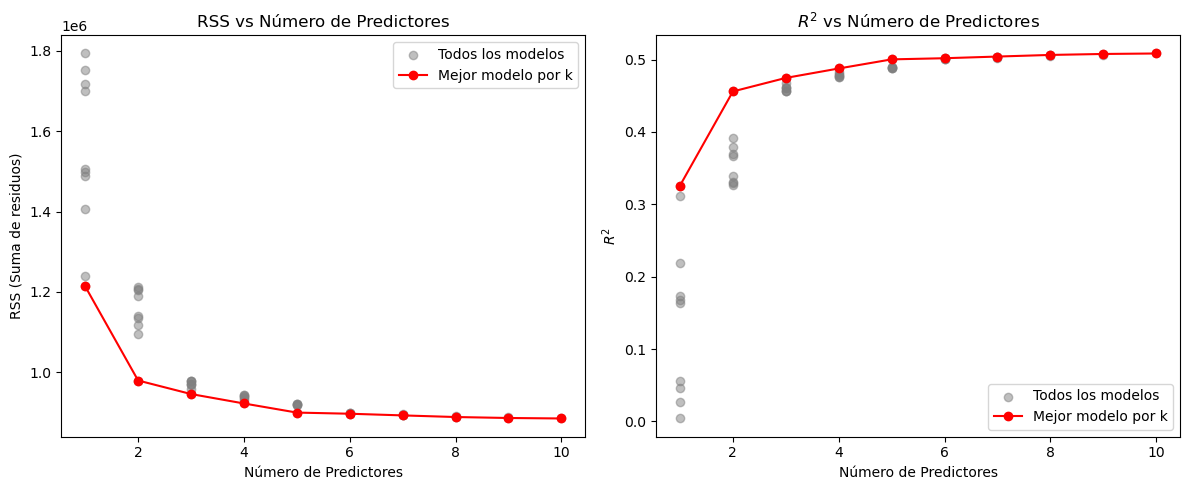

In [19]:
# Crear una figura con dos subplots (1 fila, 2 columnas) para comparar RSS y R²
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# === Gráfica 1: RSS vs Número de Predictores ===
# Graficar todos los modelos probados (puntos grises, con transparencia)
axes[0].scatter(
    graficos_forward['num_predictores'],  # eje X: número de predictores en cada modelo
    graficos_forward['rss_todos'],        # eje Y: RSS (suma de residuos) para cada modelo
    color='gray', alpha=0.5, label='Todos los modelos'  # color gris semi-transparente
)

# Graficar la curva de los mejores modelos para cada k (línea roja con círculos)
axes[0].plot(
    graficos_forward['k_values'],   # valores de k (número de predictores)
    graficos_forward['rss_mejores'],# RSS de los mejores modelos por cada k
    '-o', color='red', label='Mejor modelo por k'  # línea roja con marcadores circulares
)

# Configurar etiquetas y título del gráfico RSS
axes[0].set_xlabel('Número de Predictores')
axes[0].set_ylabel('RSS (Suma de residuos)')
axes[0].set_title('RSS vs Número de Predictores')
axes[0].legend()  # Mostrar leyenda para distinguir puntos y línea

# === Gráfica 2: R² vs Número de Predictores ===
# Graficar todos los modelos probados (puntos grises con transparencia)
axes[1].scatter(
    graficos_forward['num_predictores'],  # eje X: número de predictores
    graficos_forward['r2_todos'],         # eje Y: coeficiente de determinación R² para cada modelo
    color='gray', alpha=0.5, label='Todos los modelos'  # color gris semi-transparente
)

# Graficar la curva con los mejores modelos para cada k (línea roja con círculos)
axes[1].plot(
    graficos_forward['k_values'],   # valores de k (número de predictores)
    graficos_forward['r2_mejores'], # R² de los mejores modelos por cada k
    '-o', color='red', label='Mejor modelo por k'  # línea roja con marcadores circulares
)

# Configurar etiquetas y título del gráfico R²
axes[1].set_xlabel('Número de Predictores')
axes[1].set_ylabel('$R^2$')  # Usamos LaTeX para mostrar el símbolo R al cuadrado
axes[1].set_title('$R^2$ vs Número de Predictores')
axes[1].legend()  # Mostrar leyenda

# Ajustar el layout para que no se monten los gráficos y mostrar la figura
plt.tight_layout()
plt.show()


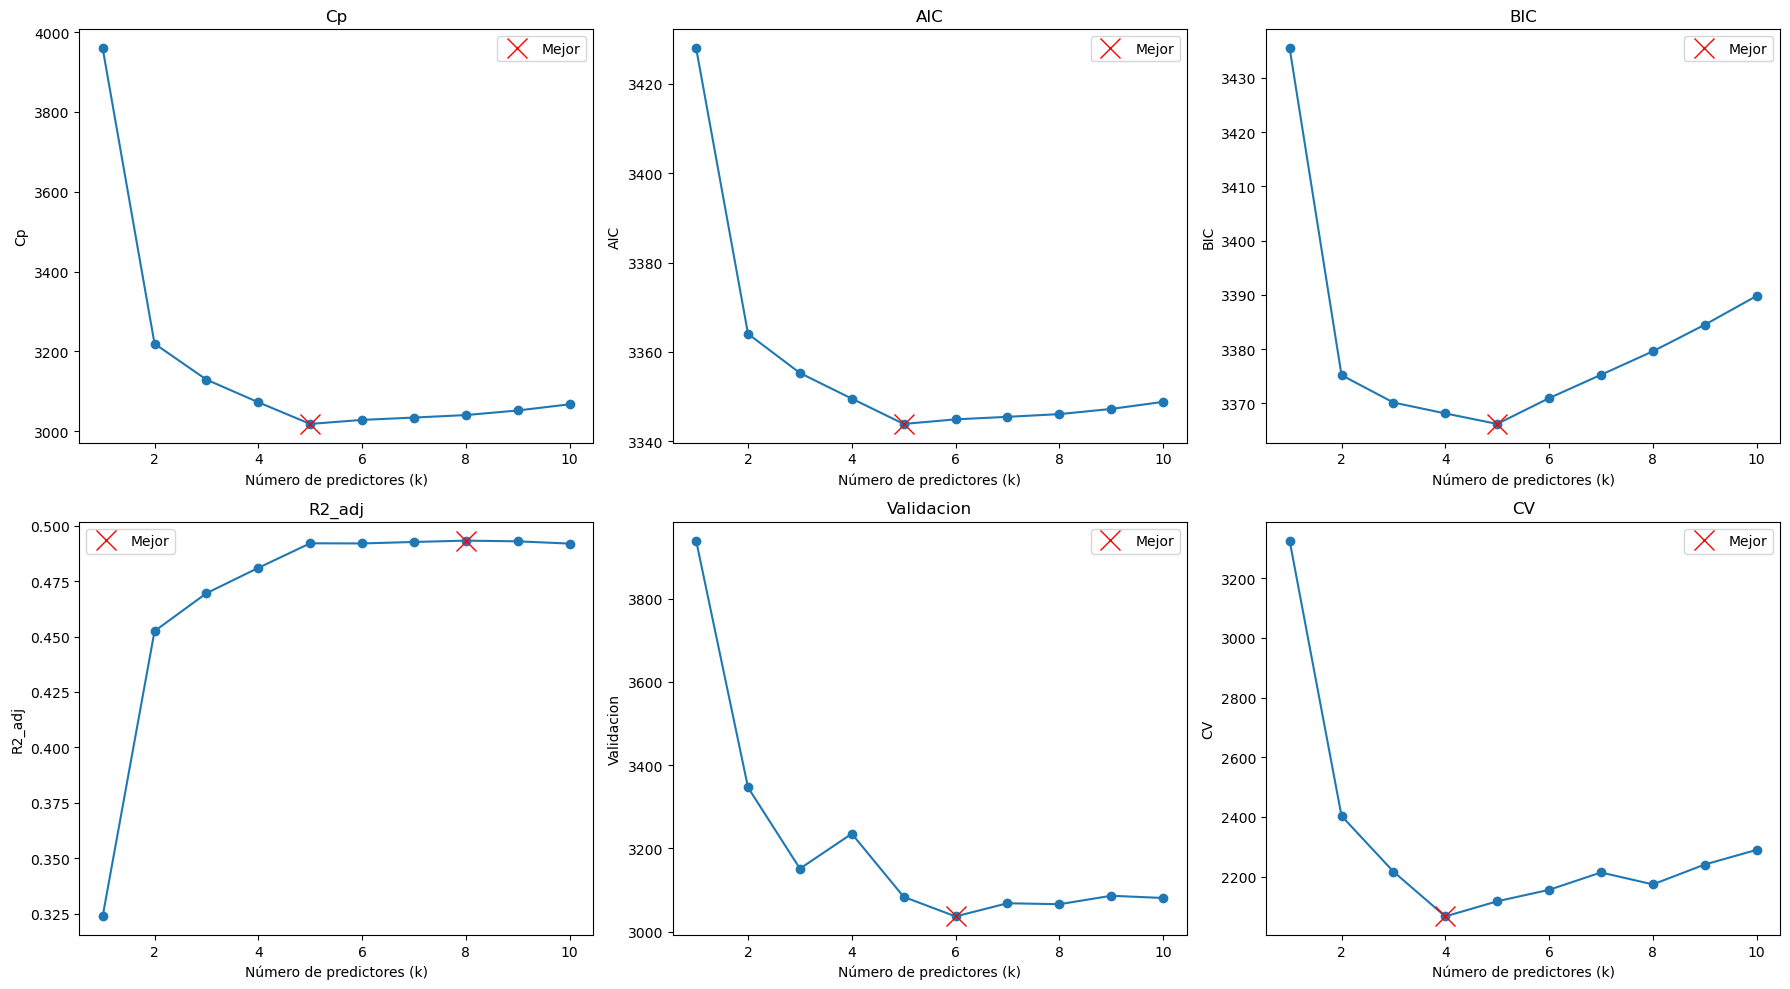

In [20]:
# Lista de criterios que se quieren graficar (deben coincidir con columnas del DataFrame)
criterios = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']

# Crear una figura con 6 subplots organizados en 2 filas y 3 columnas
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Aplanar la matriz de ejes para poder iterar fácilmente
axs = axs.ravel()

# Iterar sobre cada criterio y su índice para graficar
for i, criterio in enumerate(criterios):
    # Extraer los datos de k y el criterio correspondiente, descartando filas con NaN
    data = resultados_df_forward[['k', criterio]].dropna()

    # Graficar el valor del criterio en función del número de predictores k
    axs[i].plot(data['k'], data[criterio], marker='o', linestyle='-')

    # Determinar cuál es el mejor valor según el criterio:
    # Para R2_adj se busca el máximo, para los demás el mínimo
    if criterio == 'R2_adj':
        best_idx = data[criterio].idxmax()
    else:
        best_idx = data[criterio].idxmin()

    # Obtener el valor de k y el valor del criterio para el mejor modelo
    best_k = data.loc[best_idx, 'k']
    best_val = data.loc[best_idx, criterio]

    # Marcar con una cruz roja el punto del mejor modelo en el gráfico
    axs[i].plot(best_k, best_val, 'x', markersize=15, label='Mejor', color='red')

    # Poner título, etiquetas y leyenda en cada subplot
    axs[i].set_title(criterio)
    axs[i].set_xlabel('Número de predictores (k)')
    axs[i].set_ylabel(criterio)
    axs[i].legend()

# Ajustar el layout para que los subplots no se superpongan y mostrar la figura
plt.tight_layout()
plt.show()


### Backward Stepwise Selection

Basado en el **Algoritmo 3.3**

In [21]:
def backward_stepwise_selection(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # Número de predictores
    n = len(y)  # Número de observaciones
    predictores = X.columns  # Nombres de las columnas de X
    predictores_seleccionados = set(predictores)  # Inicializa un conjunto con todos los predictores
    resultados_por_k = []  # Almacena los modelos seleccionados en cada paso

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale

    # Modelo completo (con todos los predictores)
    X_completo = add_constant(X)  # Agregar la constante
    modelo_completo = OLS(y, X_completo).fit()
    resultados_por_k.append({
        'k': p,  # El modelo completo tiene p predictores
        'modelo': modelo_completo,
        'predictores': predictores.tolist()
    })

    # Iterar desde el número de predictores p hasta 1
    for k in range(p, 0, -1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_predictores = None  # Inicializa la mejor combinación de predictores
        predictores_a_eliminar = None  # Predictor a eliminar en cada paso
        
        # Evaluar todos los modelos que eliminan un predictor
        for predictor in predictores_seleccionados:
            predictores_a_probar = list(resultados_por_k[p - k]['predictores'])
            predictores_a_probar.remove(predictor)
            X_k = add_constant(X[predictores_a_probar])  # Agregar la constante
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS
            r2 = modelo.rsquared  # Obtiene el R² del modelo
            
            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = predictores_a_probar
                predictores_a_eliminar = predictor  # Corregir aquí: asignamos a la variable correcta

        # Después de elegir el mejor predictor, eliminarlo de los predictores seleccionados
        predictores_seleccionados.remove(predictores_a_eliminar)  # Usar la variable correcta

        # Almacena los resultados del paso k
        resultados_por_k.append({
            'k': k - 1,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores,
        })

    # Inicializa las métricas para comparar modelos
    metricas = []
    mejores_modelos_cv = []

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            metricas.append(validacion(modelo, X_val, y_val, list(res['predictores'])))

        # Selección según validación cruzada
        elif criterio == 'cv':
            best_model_k, best_mse_k, mse_scores_k = validacion_cruzada(X_train, y_train, list(res['predictores']), k_cv )
            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica

In [22]:
def Backward_Stepwise_Selection(X, y, criterio=None, X_val=None, y_val=None, k_cv=5, verbose=True):
    # Obtener número de predictores (p) y número de observaciones (n)
    p = X.shape[1]
    n = len(y)
    predictores = X.columns  # nombres de las variables predictoras
    resultados_por_k = []    # lista para guardar resultados por cada tamaño de modelo

    # Ajustar modelo completo con todos los predictores para estimar sigma^2
    X_full = add_constant(X)
    modelo_full = OLS(y, X_full).fit()
    sigma2_hat = modelo_full.scale  # estimación del error residual

    # Inicializar el conjunto de predictores con todos los predictores
    predictores_seleccionados = list(predictores)
    modelo_completo = OLS(y, add_constant(X[predictores_seleccionados])).fit()
    rss_full = np.sum(modelo_completo.resid ** 2)  # RSS del modelo completo
    r2_full = modelo_completo.rsquared             # R^2 del modelo completo

    # Guardar el modelo completo como punto inicial (k = p)
    resultados_por_k.append({
        'k': p,
        'modelo': modelo_completo,
        'predictores': predictores_seleccionados.copy()
    })

    # Inicializar listas para graficar RSS y R^2 de todos los modelos evaluados y los mejores
    num_predictores = []
    rss_todos = []
    r2_todos = []
    rss_mejores = [rss_full]
    r2_mejores = [r2_full]
    k_values = [p]

    # Proceso backward: eliminar un predictor a la vez desde modelo completo hasta modelo vacío
    for k in range(p, 0, -1):
        mejor_rss = np.inf
        mejor_r2 = -np.inf
        mejor_modelo_k = None
        mejor_comb = None

        # Evaluar todos los modelos con un predictor menos (eliminando uno a la vez)
        for predictor in predictores_seleccionados:
            subset = predictores_seleccionados.copy()
            subset.remove(predictor)  # eliminar predictor actual
            X_k = add_constant(X[subset])
            modelo = OLS(y, X_k).fit()
            rss = np.sum(modelo.resid ** 2)  # RSS del modelo candidato
            r2 = modelo.rsquared              # R^2 del modelo candidato

            # Guardar datos para graficar todos los modelos evaluados
            num_predictores.append(len(subset))
            rss_todos.append(rss)
            r2_todos.append(r2)

            # Actualizar mejor modelo para este tamaño k según menor RSS
            if rss < mejor_rss:
                mejor_rss = rss
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        # Actualizar el conjunto de predictores con el mejor subconjunto encontrado
        predictores_seleccionados = mejor_comb.copy()
        # Guardar el mejor modelo para tamaño k
        resultados_por_k.append({
            'k': len(mejor_comb),
            'modelo': mejor_modelo_k,
            'predictores': mejor_comb
        })
        rss_mejores.append(mejor_rss)
        r2_mejores.append(mejor_r2)
        k_values.append(len(mejor_comb))

    # Crear un DataFrame para almacenar las métricas de los modelos para cada k
    resultados_df = pd.DataFrame({
        'k': [res['k'] for res in resultados_por_k],
        'Cp': np.nan,
        'AIC': np.nan,
        'BIC': np.nan,
        'R2_adj': np.nan,
        'Validacion': np.nan,
        'CV': np.nan
    })

    # Calcular métricas para cada modelo guardado en resultados_por_k
    for i, res in enumerate(resultados_por_k):
        modelo = res['modelo']
        k = res['k']
        pred = list(res['predictores'])

        if k == 0:  # si no hay predictores, saltar
            continue

        X_k = add_constant(X[pred])
        modelo_k = OLS(y, X_k).fit()
        rss = np.sum(modelo_k.resid ** 2)

        # Calcular Cp usando estimación sigma^2 del modelo completo
        resultados_df.loc[i, 'Cp'] = (rss + 2 * k * sigma2_hat) / n
        resultados_df.loc[i, 'AIC'] = modelo_k.aic
        resultados_df.loc[i, 'BIC'] = modelo_k.bic
        resultados_df.loc[i, 'R2_adj'] = modelo_k.rsquared_adj

        # Si hay datos de validación, calcular error de validación
        if X_val is not None and y_val is not None:
            val_error = validacion(modelo_k, X_val, y_val, pred)
            resultados_df.loc[i, 'Validacion'] = val_error

        # Calcular error por validación cruzada k_cv-folds
        _, cv_mse, _ = validacion_cruzada(X, y, pred, k_cv)
        resultados_df.loc[i, 'CV'] = cv_mse

    # Definir criterios válidos para evaluar
    criterios_validos = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']
    if criterio is None or criterio == 'todos':
        criterios_a_evaluar = criterios_validos
    elif criterio in criterios_validos:
        criterios_a_evaluar = [criterio]
    else:
        raise ValueError(f"Criterio inválido: {criterio}. Debe ser uno de {criterios_validos} o None/'todos'.")

    mejores_modelos = {}
    # Para cada criterio, seleccionar el mejor modelo (max R2_adj, min resto)
    for crit in criterios_a_evaluar:
        if crit == 'R2_adj':
            idx_mejor = resultados_df[crit].idxmax()
        else:
            idx_mejor = resultados_df[crit].idxmin()

        mejor_modelo = resultados_por_k[idx_mejor]
        mejores_modelos[crit] = {
            'k': mejor_modelo['k'],
            'predictores': mejor_modelo['predictores'],
            'metrica': resultados_df.loc[idx_mejor, crit],
            'modelo': mejor_modelo['modelo']
        }

        # Imprimir resumen del mejor modelo si verbose=True
        if verbose:
            print(f"\n========= Mejor modelo según {crit} =========")
            print(f"  k = {mejor_modelo['k']}")
            print(f"  Predictores: {mejor_modelo['predictores']}")
            print(f"  Métrica ({crit}): {resultados_df.loc[idx_mejor, crit]:.4f}")
            print(mejor_modelo['modelo'].summary())

    # Preparar datos para graficar RSS y R2 de todos los modelos y los mejores
    graficos_data = {
        'num_predictores': num_predictores,
        'rss_todos': rss_todos,
        'r2_todos': r2_todos,
        'rss_mejores': rss_mejores,
        'r2_mejores': r2_mejores,
        'k_values': k_values
    }

    # Devolver DataFrame con métricas, datos para graficar y mejores modelos según criterio
    return resultados_df, graficos_data, mejores_modelos


In [23]:
resultados_df_backward, graficos_backward, mejores_backward = Backward_Stepwise_Selection(X_train, y_train, criterio=None, X_val=X_val, y_val=y_val)


========= Mejor modelo según Cp =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (Cp): 3017.2779
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Wed, 21 May 2025   Prob (F-statistic):           4.70e-43
Time:                        18:47:40   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [24]:
resumen = pd.DataFrame([
    {
        'Criterio': crit,            
        'k': info['k'],
        'Predictores': ', '.join(info['predictores'])
    }
for crit, info in mejores_backward.items()
])

print("\nResumen de los mejores modelos por criterio:")
resumen


Resumen de los mejores modelos por criterio:


,Criterio,k,Predictores
0,Cp,6,"sex, bmi, bp, s1, s4, s5"
1,AIC,6,"sex, bmi, bp, s1, s4, s5"
2,BIC,6,"sex, bmi, bp, s1, s4, s5"
3,R2_adj,7,"sex, bmi, bp, s1, s2, s4, s5"
4,Validacion,7,"sex, bmi, bp, s1, s2, s4, s5"
5,CV,5,"bmi, bp, s1, s4, s5"


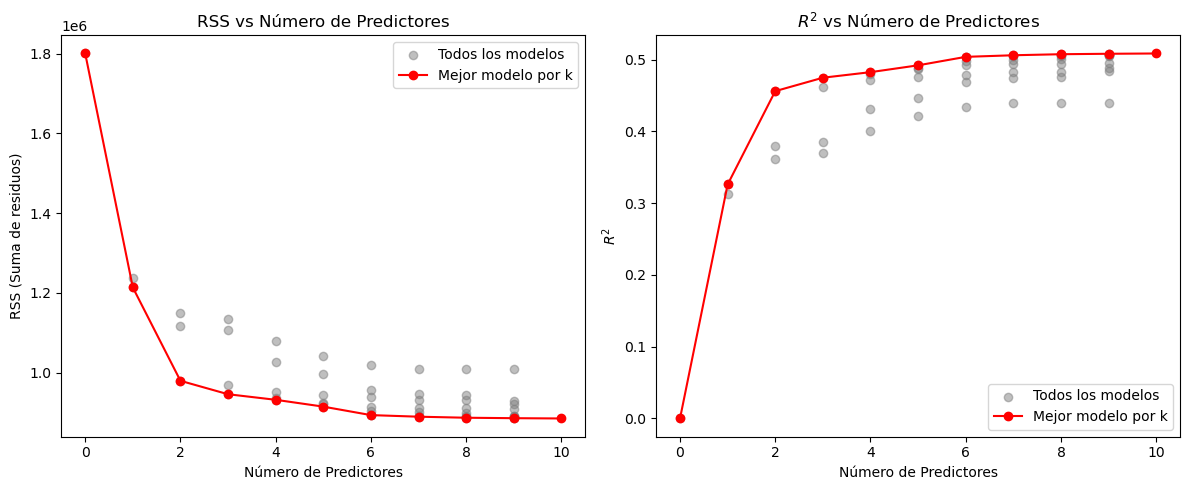

In [25]:
# Crear una figura con dos subplots en una fila y dos columnas, tamaño 12x5 pulgadas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# === Gráfica RSS vs Número de Predictores ===
# Scatter plot para mostrar todos los modelos evaluados (puntos grises, semi-transparente)
axes[0].scatter(
    graficos_backward['num_predictores'], graficos_backward['rss_todos'],
    color='gray', alpha=0.5, label='Todos los modelos'
)
# Línea roja con marcadores para mostrar el mejor modelo encontrado para cada número de predictores
axes[0].plot(
    graficos_backward['k_values'], graficos_backward['rss_mejores'],
    '-o', color='red', label='Mejor modelo por k'
)
# Etiqueta del eje X
axes[0].set_xlabel('Número de Predictores')
# Etiqueta del eje Y
axes[0].set_ylabel('RSS (Suma de residuos)')
# Título de la gráfica
axes[0].set_title('RSS vs Número de Predictores')
# Mostrar la leyenda para identificar las series
axes[0].legend()

# === Gráfica R² vs Número de Predictores ===
# Scatter plot para mostrar todos los modelos evaluados (puntos grises, semi-transparente)
axes[1].scatter(
    graficos_backward['num_predictores'], graficos_backward['r2_todos'],
    color='gray', alpha=0.5, label='Todos los modelos'
)
# Línea roja con marcadores para mostrar el mejor modelo encontrado para cada número de predictores
axes[1].plot(
    graficos_backward['k_values'], graficos_backward['r2_mejores'],
    '-o', color='red', label='Mejor modelo por k'
)
# Etiqueta del eje X
axes[1].set_xlabel('Número de Predictores')
# Etiqueta del eje Y con notación matemática para R²
axes[1].set_ylabel('$R^2$')
# Título de la gráfica
axes[1].set_title('$R^2$ vs Número de Predictores')
# Mostrar la leyenda para identificar las series
axes[1].legend()

# Ajustar automáticamente los espacios entre subplots para evitar solapamientos
plt.tight_layout()
# Mostrar las gráficas en pantalla
plt.show()


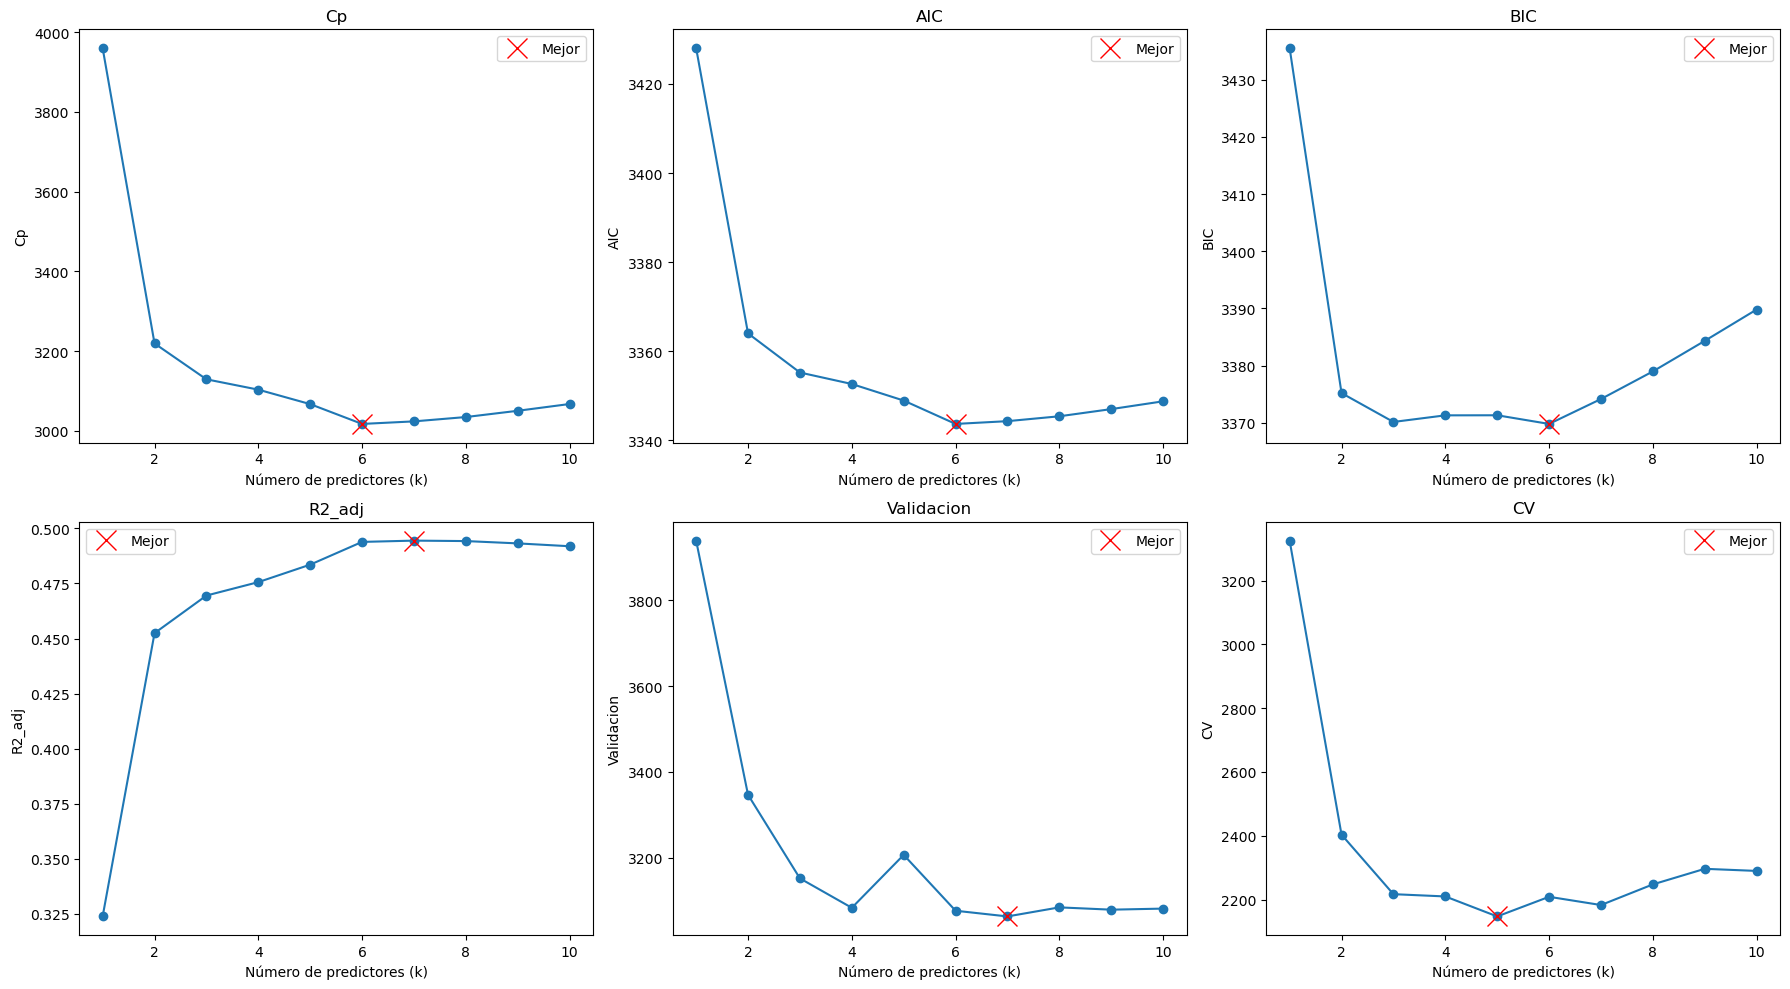

In [26]:
# Lista con los nombres de los criterios que vamos a graficar (deben coincidir con columnas del DataFrame)
criterios = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']

# Crear una figura con una grilla de subplots de 2 filas y 3 columnas, tamaño total 18x10 pulgadas
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
# Aplanar el array de ejes para acceder a ellos fácilmente con un índice simple
axs = axs.ravel()

# Iterar sobre cada criterio y el índice correspondiente para graficar
for i, criterio in enumerate(criterios):
    # Tomar solo las filas sin valores nulos para el criterio actual y las columnas 'k' y el criterio
    data = resultados_df_backward[['k', criterio]].dropna()

    # Graficar línea con puntos para mostrar la evolución del criterio respecto al número de predictores k
    axs[i].plot(data['k'], data[criterio], marker='o', linestyle='-')

    # Encontrar el índice del mejor valor según el criterio:
    # Para R2_adj se busca el máximo (mayor ajuste), para los demás el mínimo (menor error o penalización)
    if criterio == 'R2_adj':
        best_idx = data[criterio].idxmax()
    else:
        best_idx = data[criterio].idxmin()

    # Obtener el número de predictores y el valor óptimo del criterio en ese índice
    best_k = data.loc[best_idx, 'k']
    best_val = data.loc[best_idx, criterio]

    # Marcar en la gráfica con una 'x' roja grande el punto del mejor modelo según ese criterio
    axs[i].plot(best_k, best_val, 'x', markersize=15, label='Mejor', color='red')

    # Poner título con el nombre del criterio
    axs[i].set_title(criterio)
    # Etiqueta del eje X: número de predictores
    axs[i].set_xlabel('Número de predictores (k)')
    # Etiqueta del eje Y: nombre del criterio
    axs[i].set_ylabel(criterio)
    # Mostrar leyenda para el marcador del mejor modelo
    axs[i].legend()

# Ajustar el layout para evitar que las etiquetas o títulos se solapen
plt.tight_layout()
# Mostrar todas las gráficas
plt.show()


In [27]:
def Hybrid_Stepwise_Selection(X, y, criterio=None, X_val=None, y_val=None, k_cv=5, verbose=True):
    p = X.shape[1]
    n = len(y)
    predictores = list(X.columns)
    restantes = set(predictores)
    seleccionados = []

    resultados_por_k = []

    # Modelo nulo
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()
    resultados_por_k.append({'k': 0, 'modelo': modelo_nulo, 'predictores': []})

    # Ajustar modelo completo para estimar varianza residual
    sigma2_hat = OLS(y, add_constant(X)).fit().scale

    # Variables para gráficos
    num_predictores, rss_todos, r2_todos = [], [], []
    rss_mejores, r2_mejores, k_values = [], [], []

    for k in range(1, p + 1):
        # ========== FORWARD STEP ==========
        mejor_rss, mejor_r2 = np.inf, -np.inf
        mejor_modelo = None
        mejor_agregado = None

        for variable in restantes:
            candidatos = seleccionados + [variable]
            X_k = add_constant(X[candidatos])
            modelo = OLS(y, X_k).fit()
            rss = np.sum(modelo.resid ** 2)
            r2 = modelo.rsquared

            num_predictores.append(len(candidatos))
            rss_todos.append(rss)
            r2_todos.append(r2)

            if rss < mejor_rss:
                mejor_rss = rss
                mejor_r2 = r2
                mejor_modelo = modelo
                mejor_agregado = variable

        if mejor_agregado is None:
            break

        seleccionados.append(mejor_agregado)
        restantes.remove(mejor_agregado)

        # ========== BACKWARD STEP ==========
        mejor_modelo_backward = mejor_modelo
        cambio = True
        while cambio and len(seleccionados) > 1:
            cambio = False
            for var in seleccionados:
                candidatos = [v for v in seleccionados if v != var]
                X_k = add_constant(X[candidatos])
                modelo = OLS(y, X_k).fit()
                rss = np.sum(modelo.resid ** 2)

                if rss < mejor_rss:
                    mejor_rss = rss
                    mejor_r2 = modelo.rsquared
                    mejor_modelo_backward = modelo
                    seleccionados = candidatos
                    restantes.add(var)
                    cambio = True
                    break

        resultados_por_k.append({
            'k': len(seleccionados),
            'modelo': mejor_modelo_backward,
            'predictores': seleccionados.copy()
        })

        rss_mejores.append(mejor_rss)
        r2_mejores.append(mejor_r2)
        k_values.append(len(seleccionados))

        if len(restantes) == 0:
            break

    # ======== MÉTRICAS ========
    resultados_df = pd.DataFrame({
        'k': [res['k'] for res in resultados_por_k],
        'Cp': np.nan,
        'AIC': np.nan,
        'BIC': np.nan,
        'R2_adj': np.nan,
        'Validacion': np.nan,
        'CV': np.nan
    })

    for i, res in enumerate(resultados_por_k):
        if res['k'] == 0:
            continue
        modelo_k = res['modelo']
        pred = res['predictores']
        X_k = add_constant(X[pred])
        modelo_k = OLS(y, X_k).fit()
        rss = np.sum(modelo_k.resid ** 2)
        resultados_df.loc[i, 'Cp'] = (rss + 2 * len(pred) * sigma2_hat) / n
        resultados_df.loc[i, 'AIC'] = modelo_k.aic
        resultados_df.loc[i, 'BIC'] = modelo_k.bic
        resultados_df.loc[i, 'R2_adj'] = modelo_k.rsquared_adj

        if X_val is not None and y_val is not None:
            val_error = validacion(modelo_k, X_val, y_val, pred)
            resultados_df.loc[i, 'Validacion'] = val_error

        _, cv_mse, _ = validacion_cruzada(X, y, pred, k_cv)
        resultados_df.loc[i, 'CV'] = cv_mse

    criterios_validos = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']
    if criterio is None or criterio == 'todos':
        criterios_a_evaluar = criterios_validos
    elif criterio in criterios_validos:
        criterios_a_evaluar = [criterio]
    else:
        raise ValueError(f"Criterio inválido: {criterio}. Debe ser uno de {criterios_validos} o None/'todos'.")

    mejores_modelos = {}
    for crit in criterios_a_evaluar:
        idx_mejor = resultados_df[crit].idxmax() if crit == 'R2_adj' else resultados_df[crit].idxmin()
        mejor_modelo = resultados_por_k[idx_mejor]
        mejores_modelos[crit] = {
            'k': mejor_modelo['k'],
            'predictores': mejor_modelo['predictores'],
            'metrica': resultados_df.loc[idx_mejor, crit],
            'modelo': mejor_modelo['modelo']
        }

        if verbose:
            print(f"\n========= Mejor modelo según {crit} =========")
            print(f"  k = {mejor_modelo['k']}")
            print(f"  Predictores: {mejor_modelo['predictores']}")
            print(f"  Métrica ({crit}): {resultados_df.loc[idx_mejor, crit]:.4f}")
            print(mejor_modelo['modelo'].summary())

    graficos_data = {
        'num_predictores': num_predictores,
        'rss_todos': rss_todos,
        'r2_todos': r2_todos,
        'rss_mejores': rss_mejores,
        'r2_mejores': r2_mejores,
        'k_values': k_values
    }

    return resultados_df, graficos_data, mejores_modelos


In [28]:
resultados_df_hybrid, graficos_hybrid, mejores_hybrid = Hybrid_Stepwise_Selection(X_train, y_train, criterio=None, X_val=X_val, y_val=y_val)


========= Mejor modelo según Cp =========
  k = 5
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex']
  Métrica (Cp): 3018.0770
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Wed, 21 May 2025   Prob (F-statistic):           1.60e-43
Time:                        18:47:43   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [29]:
resumen = pd.DataFrame([
    {
        'Criterio': crit,            
        'k': info['k'],
        'Predictores': ', '.join(info['predictores'])
    }
for crit, info in mejores_hybrid.items()
])

print("\nResumen de los mejores modelos por criterio:")
resumen


Resumen de los mejores modelos por criterio:


,Criterio,k,Predictores
0,Cp,5,"bmi, s5, bp, s3, sex"
1,AIC,5,"bmi, s5, bp, s3, sex"
2,BIC,5,"bmi, s5, bp, s3, sex"
3,R2_adj,8,"bmi, s5, bp, s3, sex, s1, s4, s2"
4,Validacion,6,"bmi, s5, bp, s3, sex, s1"
5,CV,4,"bmi, s5, bp, s3"


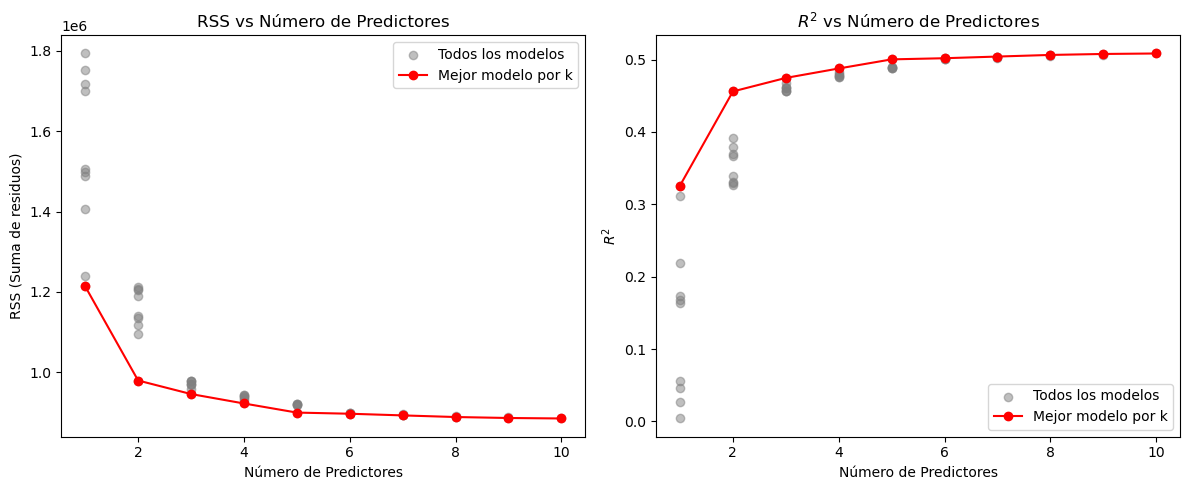

In [30]:
# Crear una figura con dos subplots en una fila y dos columnas, tamaño 12x5 pulgadas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# === Gráfica RSS vs Número de Predictores ===
# Scatter plot para mostrar todos los modelos evaluados (puntos grises, semi-transparente)
axes[0].scatter(
    graficos_hybrid['num_predictores'], graficos_hybrid['rss_todos'],
    color='gray', alpha=0.5, label='Todos los modelos'
)
# Línea roja con marcadores para mostrar el mejor modelo encontrado para cada número de predictores
axes[0].plot(
    graficos_hybrid['k_values'], graficos_hybrid['rss_mejores'],
    '-o', color='red', label='Mejor modelo por k'
)
# Etiqueta del eje X
axes[0].set_xlabel('Número de Predictores')
# Etiqueta del eje Y
axes[0].set_ylabel('RSS (Suma de residuos)')
# Título de la gráfica
axes[0].set_title('RSS vs Número de Predictores')
# Mostrar la leyenda para identificar las series
axes[0].legend()

# === Gráfica R² vs Número de Predictores ===
# Scatter plot para mostrar todos los modelos evaluados (puntos grises, semi-transparente)
axes[1].scatter(
    graficos_hybrid['num_predictores'], graficos_hybrid['r2_todos'],
    color='gray', alpha=0.5, label='Todos los modelos'
)
# Línea roja con marcadores para mostrar el mejor modelo encontrado para cada número de predictores
axes[1].plot(
    graficos_hybrid['k_values'], graficos_hybrid['r2_mejores'],
    '-o', color='red', label='Mejor modelo por k'
)
# Etiqueta del eje X
axes[1].set_xlabel('Número de Predictores')
# Etiqueta del eje Y con notación matemática para R²
axes[1].set_ylabel('$R^2$')
# Título de la gráfica
axes[1].set_title('$R^2$ vs Número de Predictores')
# Mostrar la leyenda para identificar las series
axes[1].legend()

# Ajustar automáticamente los espacios entre subplots para evitar solapamientos
plt.tight_layout()
# Mostrar las gráficas en pantalla
plt.show()


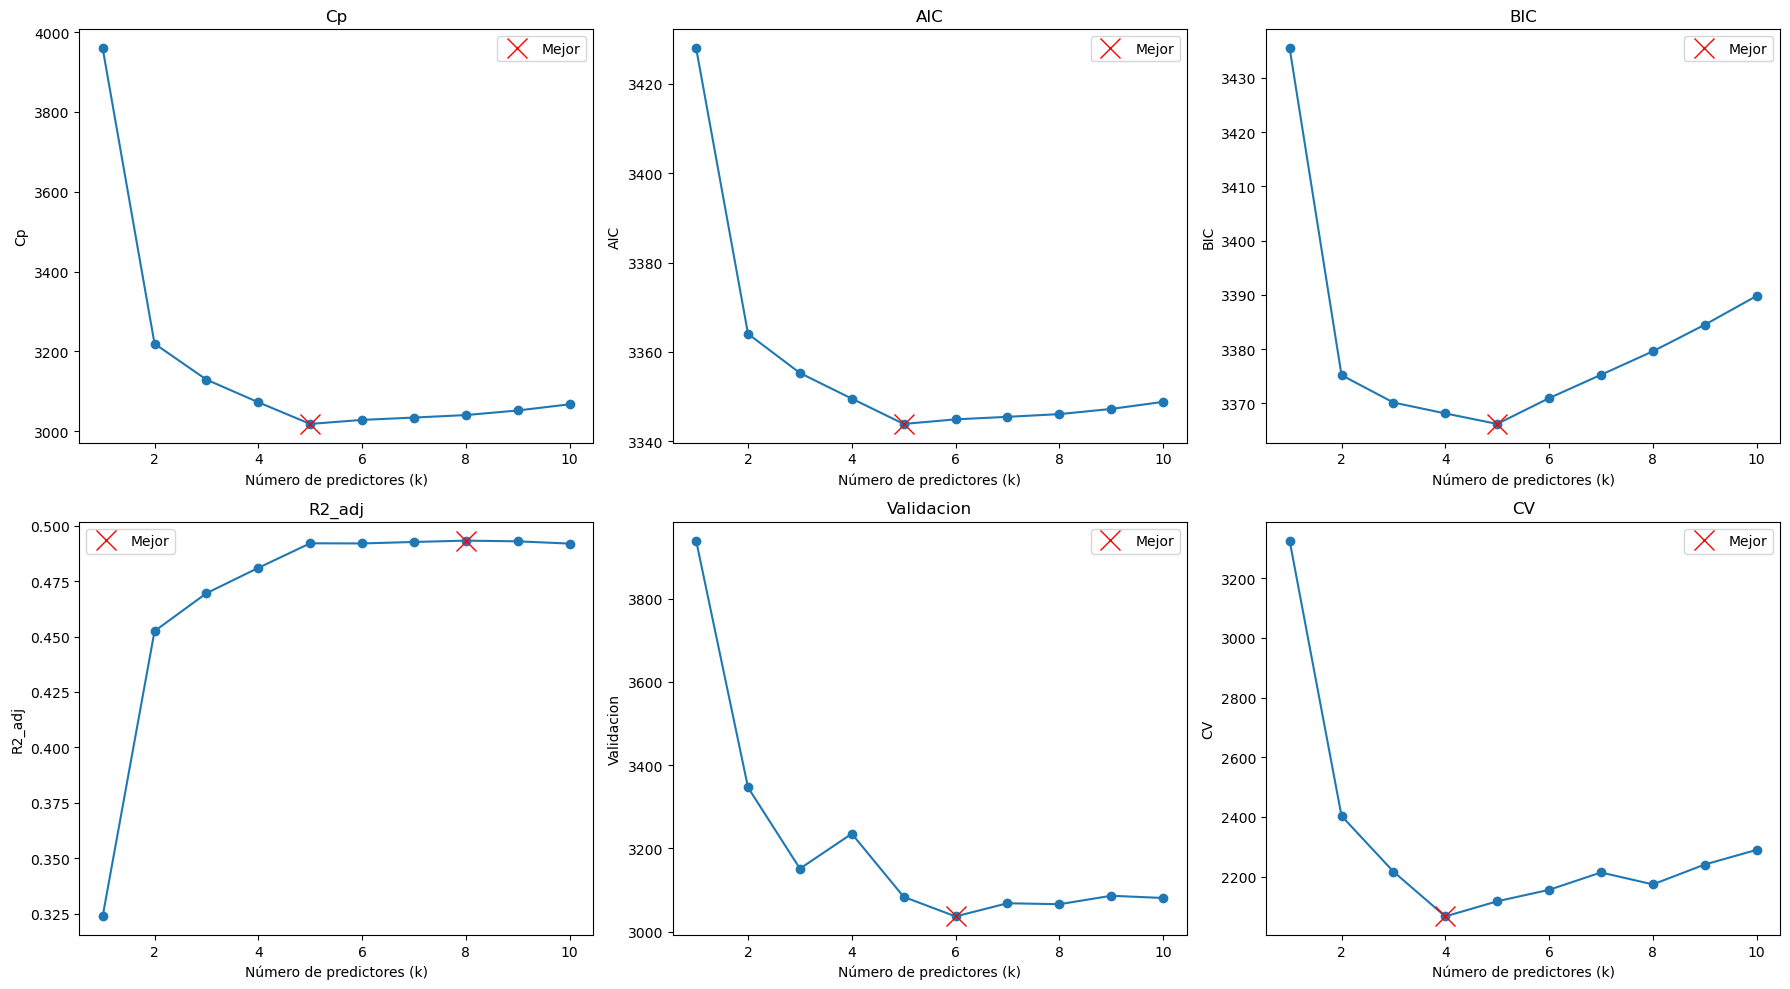

In [31]:
# Lista con los nombres de los criterios que vamos a graficar (deben coincidir con columnas del DataFrame)
criterios = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']

# Crear una figura con una grilla de subplots de 2 filas y 3 columnas, tamaño total 18x10 pulgadas
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
# Aplanar el array de ejes para acceder a ellos fácilmente con un índice simple
axs = axs.ravel()

# Iterar sobre cada criterio y el índice correspondiente para graficar
for i, criterio in enumerate(criterios):
    # Tomar solo las filas sin valores nulos para el criterio actual y las columnas 'k' y el criterio
    data = resultados_df_hybrid[['k', criterio]].dropna()

    # Graficar línea con puntos para mostrar la evolución del criterio respecto al número de predictores k
    axs[i].plot(data['k'], data[criterio], marker='o', linestyle='-')

    # Encontrar el índice del mejor valor según el criterio:
    # Para R2_adj se busca el máximo (mayor ajuste), para los demás el mínimo (menor error o penalización)
    if criterio == 'R2_adj':
        best_idx = data[criterio].idxmax()
    else:
        best_idx = data[criterio].idxmin()

    # Obtener el número de predictores y el valor óptimo del criterio en ese índice
    best_k = data.loc[best_idx, 'k']
    best_val = data.loc[best_idx, criterio]

    # Marcar en la gráfica con una 'x' roja grande el punto del mejor modelo según ese criterio
    axs[i].plot(best_k, best_val, 'x', markersize=15, label='Mejor', color='red')

    # Poner título con el nombre del criterio
    axs[i].set_title(criterio)
    # Etiqueta del eje X: número de predictores
    axs[i].set_xlabel('Número de predictores (k)')
    # Etiqueta del eje Y: nombre del criterio
    axs[i].set_ylabel(criterio)
    # Mostrar leyenda para el marcador del mejor modelo
    axs[i].legend()

# Ajustar el layout para evitar que las etiquetas o títulos se solapen
plt.tight_layout()
# Mostrar todas las gráficas
plt.show()

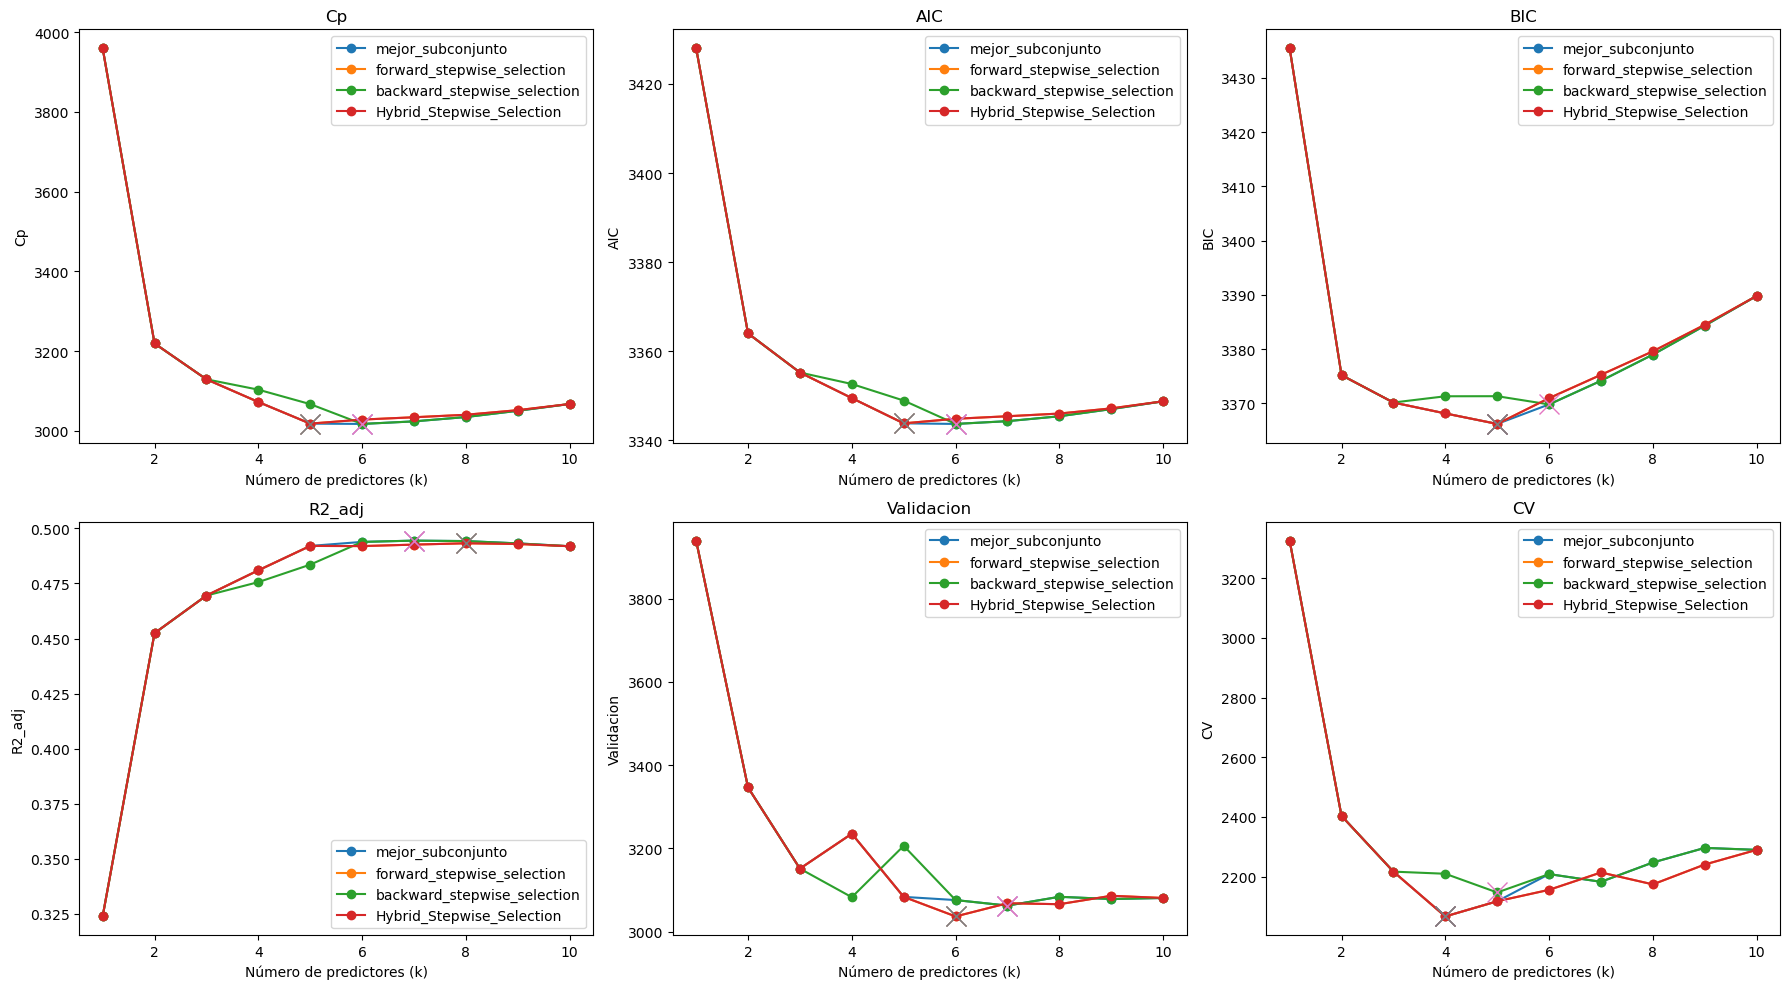

In [32]:
# Lista con los nombres de los criterios que vamos a graficar (deben coincidir con columnas del DataFrame)
criterios = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']

# Crear una figura con una grilla de subplots de 2 filas y 3 columnas, tamaño total 18x10 pulgadas
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
# Aplanar el array de ejes para acceder a ellos fácilmente con un índice simple
axs = axs.ravel()

# Iterar sobre cada criterio y el índice correspondiente para graficar
for i, criterio in enumerate(criterios):
    # Tomar solo las filas sin valores nulos para el criterio actual y las columnas 'k' y el criterio
    data_best = resultados_df[['k', criterio]].dropna()
    data_fwd = resultados_df_forward[['k', criterio]].dropna()
    data_bck = resultados_df_backward[['k', criterio]].dropna()
    data_hyb = resultados_df_hybrid[['k', criterio]].dropna()

    # Graficar línea con puntos para mostrar la evolución del criterio respecto al número de predictores k
    axs[i].plot(data_best['k'], data_best[criterio], marker='o', linestyle='-', label='mejor_subconjunto')
    axs[i].plot(data_fwd['k'], data_fwd[criterio], marker='o', linestyle='-', label='forward_stepwise_selection')
    axs[i].plot(data_bck['k'], data_bck[criterio], marker='o', linestyle='-', label='backward_stepwise_selection')
    axs[i].plot(data_hyb['k'], data_hyb[criterio], marker='o', linestyle='-', label='Hybrid_Stepwise_Selection')

    # Encontrar el índice del mejor valor según el criterio:
    # Para R2_adj se busca el máximo (mayor ajuste), para los demás el mínimo (menor error o penalización)
    if criterio == 'R2_adj':
        best_idx_best = data_best[criterio].idxmax()
        best_idx_fwd = data_fwd[criterio].idxmax()
        best_idx_bck = data_bck[criterio].idxmax()
        best_idx_hyb = data_hyb[criterio].idxmax()

    else:
        best_idx_best = data_best[criterio].idxmin()
        best_idx_fwd = data_fwd[criterio].idxmin()
        best_idx_bck = data_bck[criterio].idxmin()
        best_idx_hyb = data_hyb[criterio].idxmin()

    # Obtener el número de predictores y el valor óptimo del criterio en ese índice
    best_k = data_best.loc[best_idx_best, 'k']
    best_k_fwd = data_fwd.loc[best_idx_fwd, 'k']
    best_k_bck = data_bck.loc[best_idx_bck, 'k']
    best_k_hyb = data_hyb.loc[best_idx_hyb, 'k']

    best_val = data_best.loc[best_idx_best, criterio]
    best_val_fwd = data_fwd.loc[best_idx_fwd, criterio]
    best_val_bck = data_bck.loc[best_idx_bck, criterio]
    best_val_hyb = data_hyb.loc[best_idx_hyb, criterio]

    # Marcar en la gráfica con una 'x' roja grande el punto del mejor modelo según ese criterio
    axs[i].plot(best_k, best_val, 'x', markersize=15)
    axs[i].plot(best_k_fwd, best_val_fwd, 'x', markersize=15)
    axs[i].plot(best_k_bck, best_val_bck, 'x', markersize=15)
    axs[i].plot(best_k_hyb, best_val_hyb, 'x', markersize=15)

    # Poner título con el nombre del criterio
    axs[i].set_title(criterio)
    # Etiqueta del eje X: número de predictores
    axs[i].set_xlabel('Número de predictores (k)')
    # Etiqueta del eje Y: nombre del criterio
    axs[i].set_ylabel(criterio)
    # Mostrar leyenda para el marcador del mejor modelo
    axs[i].legend()

# Ajustar el layout para evitar que las etiquetas o títulos se solapen
plt.tight_layout()
# Mostrar todas las gráficas
plt.show()

# Métodos de Penalización

Es muy importante estandarizar los datos, ya que los modelos siguientes son muy sensibles a la escala. Aunque nuestros datos ya están estandarizados, a continuación te muestro cómo se realizaría este proceso.

NOTA: El parámetro $\lambda$ se llama alpha en Sklearn. 

In [33]:
# Escalar
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

### Ridge Regression

Si simplemente queremos saber cuáles son los coeficientes que calcula la Ridge Regression para un valor específico de $\lambda$ (alpha), podemos utilizar la función **Ridge()** del módulo sklearn.linear_model. Esta permite ajustar el modelo con un valor fijo de regularización y obtener directamente los coeficientes.

In [34]:
# Crear el modelo Ridge con un valor de alpha (λ) de 10
ridge = Ridge(alpha=1)

# Ajustar el modelo Ridge a los datos estandarizados de entrenamiento
ridge.fit(X_train, y_train)

# Crear un DataFrame con los coeficientes del modelo y los nombres de las características (predictores)
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Columnas de las características del conjunto de datos de entrenamiento
    'Coefficient': ridge.coef_   # Coeficientes obtenidos por el modelo Ridge
})

# Agregar una nueva columna con los valores absolutos de los coeficientes
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Ordenar el DataFrame según el valor absoluto de los coeficientes en orden descendente
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Imprimir los coeficientes ordenados, mostrando los más influyentes primero
print("\nCoeficientes de la regresión Ridge:")
print(coef_df)


Coeficientes de la regresión Ridge:
  Feature  Coefficient  Abs_Coefficient
2     bmi   251.896962       251.896962
8      s5   221.449273       221.449273
3      bp   159.842119       159.842119
6      s3  -140.443540       140.443540
7      s4   127.552592       127.552592
9      s6   117.124198       117.124198
1     sex   -47.788039        47.788039
4      s1    26.823217        26.823217
0     age    16.617407        16.617407
5      s2     3.430260         3.430260


En cambio, si queremos encontrar para qué valor de $\lambda$ (alpha) se obtiene el mejor modelo, podemos utilizar **RidgeCV**, que realiza una validación cruzada para seleccionar automáticamente el valor óptimo de alpha. Este proceso evalúa el rendimiento del modelo en diferentes particiones de los datos y elige el alpha que minimiza el error.

NOTA: Si no especificamos sobre que alphas queremos que trabaje RidgeCV(), por defecto, trabajara con alphas=[0.1, 1.0, 10.0]

In [35]:
# Definir valores de alpha (desde 10^-6 a 10^6)
alphas = np.logspace(-6, 6, 13)

# Ajustar modelo RidgeCV con validación cruzada
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"El valor óptimo de alpha es: {ridge_cv.alpha_}")

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (Ridge Regression):")
print(coef_df) 

# Hacer predicciones en los datos de entrenamiento
y_pred = ridge_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Calcular el error cuadrático medio (MSE) promedio de la validación cruzada para cada valor de alpha (λ)
cv_mse = np.mean(ridge_cv.cv_values_, axis=0)

# Crear un DataFrame para almacenar los resultados, incluyendo los valores de alpha y los MSE promedio
results_df = pd.DataFrame({
    'Alpha (lambda)': ridge_cv.alphas,  # Valores de alpha (λ) utilizados en la validación cruzada
    'Mean Val Score (MSE)': cv_mse    # MSE promedio obtenido para cada valor de alpha
})

# Añadir una columna con el ranking de los MSE (menor MSE tiene el rango más alto)
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar el DataFrame por el ranking de MSE, de menor a mayor MSE
results_df = results_df.sort_values(by='Rank Val Score')

# Imprimir el DataFrame resultante para mostrar los valores de alpha y sus respectivos rankings de MSE
results_df

El valor óptimo de alpha es: 0.1

Coeficientes del mejor modelo (Ridge Regression):
  Feature  Coefficient  Abs_Coefficient
2     bmi   471.746709       471.746709
8      s5   403.375788       403.375788
3      bp   272.318939       272.318939
6      s3  -174.351515       174.351515
1     sex  -169.351439       169.351439
7      s4   152.561617       152.561617
9      s6   112.584900       112.584900
5      s2   -58.438721        58.438721
4      s1   -41.240039        41.240039
0     age   -28.970900        28.970900

MSE en entrenamiento: 2912.8657
R² en entrenamiento: 0.5018


,Alpha (lambda),Mean Val Score (MSE),Rank Val Score
5,0.100000,3075.591956,1.0
4,0.010000,3082.373666,2.0
3,0.001000,3088.097186,3.0
2,0.000100,3090.340110,4.0
1,0.000010,3090.634208,5.0
0,0.000001,3090.664503,6.0
6,1.000000,3491.251685,7.0
7,10.000000,5028.315134,8.0
8,100.000000,5770.694300,9.0
9,1000.000000,5872.871951,10.0


Otra forma seria aplicando **GridSearchCV** al Ridge(). Siempre tenemos que especificar los valores de alpha con los que queremos que trabaje. 

In [36]:
# Definir el grid de valores para alpha (lambda)
lambdas=np.logspace(-6, 6, 13)
param_grid = {
    'alpha': lambdas
}

# Crear un scorer basado en MSE (negativo porque scikit-learn maximiza)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Validación cruzada 
cv = KFold(n_splits=5, shuffle=True, random_state=100)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=cv,
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
best_model = grid_search.best_estimator_
print(f"\nMejor valor de alpha (lambda) seleccionado (Ridge Regression): {grid_search.best_params_['alpha']}")

# Coeficientes del mejor modelo
coefficients = best_model.coef_
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo:")
print(coef_df)

# Evaluar rendimiento en entrenamiento
y_pred = best_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Resultados detallados de la búsqueda
results = grid_search.cv_results_
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
}).sort_values(by='Rank Val Score')

print("\nResumen de la búsqueda de hiperparámetros (Ridge Regression):")
results_df


Mejor valor de alpha (lambda) seleccionado (Ridge Regression): 0.01

Coeficientes del mejor modelo:
  Feature  Coefficient  Abs_Coefficient
8      s5   533.467611       533.467611
2     bmi   523.140149       523.140149
3      bp   300.232334       300.232334
4      s1  -280.727226       280.727226
1     sex  -202.988620       202.988620
7      s4   186.593104       186.593104
5      s2    95.590412        95.590412
9      s6    90.348538        90.348538
6      s3   -73.365675        73.365675
0     age   -43.382400        43.382400

MSE en entrenamiento: 2881.8614
R² en entrenamiento: 0.5071

Resumen de la búsqueda de hiperparámetros (Ridge Regression):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
4,0.01,3048.167168,460.004512,2864.422376,113.743408,1
3,0.001,3050.507059,468.500578,2855.136777,116.953950,2
5,0.1,3050.750946,488.965585,2906.574919,112.640771,3
2,0.0001,3051.322684,473.010298,2854.561214,117.155049,4
1,0.00001,3051.448823,473.587556,2854.553240,117.157781,5
0,0.000001,3051.462070,473.646842,2854.553157,117.157809,6
6,1.0,3607.210878,528.286464,3500.532262,121.119107,7
7,10.0,5195.292330,682.127197,5097.710847,138.313639,8
8,100.0,5835.233701,751.507735,5743.420708,175.176878,9
9,1000.0,5918.382793,760.048675,5827.461404,181.178481,10


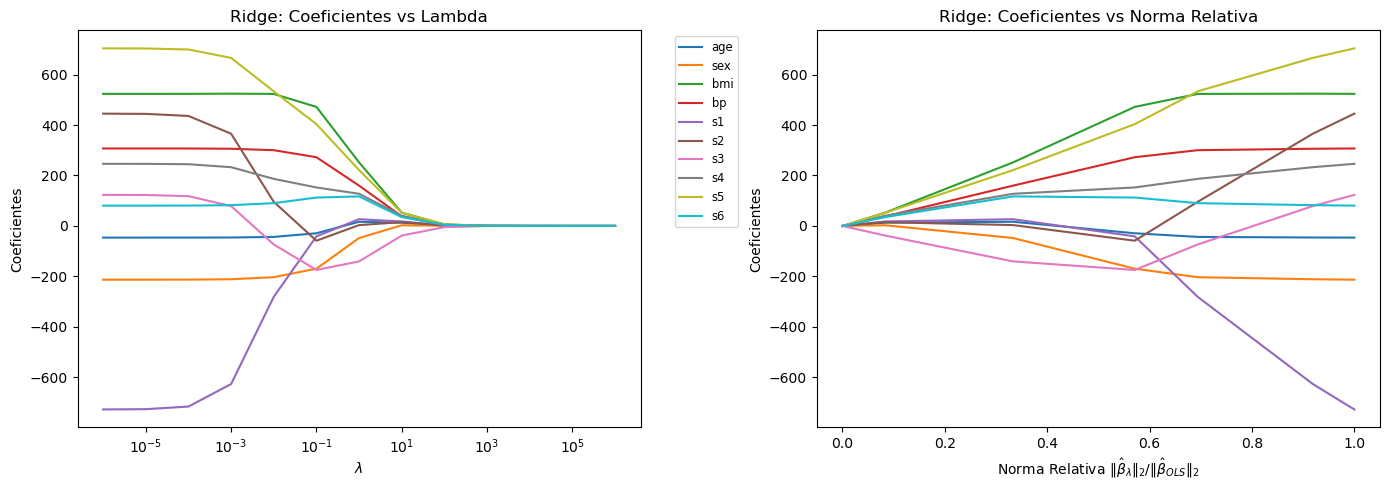

In [37]:
# Entrenar modelo OLS (alpha = 0)
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_coef = ols.coef_
ols_coef_norm = np.linalg.norm(ols_coef)

# Inicializar lista de coeficientes
coefs = []

# Entrenar modelos Ridge para cada lambda
for alpha in lambdas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)

coefs = np.array(coefs)

# Calcular norma relativa con respecto a la solución OLS
norms = np.linalg.norm(coefs, axis=1)
relative_norms = norms / ols_coef_norm

# Crear las gráficas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Izquierda: Coeficientes vs lambda
for i in range(X_train.shape[1]):
    axes[0].plot(lambdas, coefs[:, i], label=X_train.columns[i])
axes[0].set_xscale('log')
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('Coeficientes')
axes[0].set_title('Ridge: Coeficientes vs Lambda')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Derecha: Coeficientes vs norma relativa
for i in range(X_train.shape[1]):
    axes[1].plot(relative_norms, coefs[:, i], label=X_train.columns[i])
axes[1].set_xlabel(r'Norma Relativa $\|\hat{\beta}_\lambda\|_2 / \|\hat{\beta}_{OLS}\|_2$')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Ridge: Coeficientes vs Norma Relativa')

plt.tight_layout()
plt.show()

Cuando el espacio de hiperparámetros es muy amplio o el costo computacional de evaluar todas las combinaciones posibles es alto, existen alternativas más eficientes a **GridSearchCV**. Una de ellas es **RandomizedSearchCV**, que selecciona combinaciones de hiperparámetros de manera aleatoria, permitiendo controlar el número de pruebas a realizar. Esta estrategia reduce el tiempo de búsqueda en comparación con una exploración exhaustiva.

Como punto intermedio entre una búsqueda exhaustiva y una aleatoria, **HalvingRandomSearchCV** ofrece una solución aún más eficiente. Este método comienza evaluando muchas combinaciones utilizando una fracción reducida de los datos y, en cada iteración, incrementa el tamaño de la muestra. A medida que avanza, se enfoca solo en los modelos que han mostrado un mejor desempeño, lo que permite ahorrar tiempo sin sacrificar una gran precisión en la selección de los hiperparámetros.

### LASSO

Todo lo visto anteriormente con el Ridge Regression se puede aplicar también al LASSO

In [38]:
# Ajustar el modelo LASSO con un valor específico de alpha
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df_lasso = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})

# Añadir columna con los valores absolutos
coef_df_lasso['Abs_Coefficient'] = coef_df_lasso['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df_lasso = coef_df_lasso.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del modelo LASSO")
print(coef_df_lasso)


Coeficientes del modelo LASSO
  Feature  Coefficient  Abs_Coefficient
2     bmi   530.625396       530.625396
8      s5   530.212964       530.212964
3      bp   297.336082       297.336082
4      s1  -254.811341       254.811341
1     sex  -197.390983       197.390983
7      s4   188.926728       188.926728
9      s6    83.258877        83.258877
6      s3   -74.270787        74.270787
5      s2    66.338186        66.338186
0     age   -38.398183        38.398183


Si no especificamos sobre que alphas queremos que LassoCV() trabaje, este genera automáticamente una secuencia de valores basada en los datos de entrada. LassoCV calcula internamente un valor máximo de alpha (alpha_max) a partir de los datos, que es el menor valor de alpha tal que todos los coeficientes del modelo son cero. Luego crea por defecto una secuencia de n_alphas=100 valores, logarítmicamente espaciados entre alpha_max y alpha_max * 1e-3.

In [39]:
# Ajustar modelo LassoCV con validación cruzada
lasso_cv = LassoCV(cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"El valor óptimo de alpha es: {lasso_cv.alpha_:.6f}")

# Crear DataFrame con coeficientes y ordenarlos por impacto
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar top 10 características más relevantes
print("\nCoeficientes del mejor modelo (Lasso):")
print(coef_df.head(10))

# Hacer predicciones en los datos de entrenamiento
y_pred = lasso_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Obtener el MSE promedio por alpha
cv_mse = np.mean(lasso_cv.mse_path_, axis=1)

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Alpha (lambda)': lasso_cv.alphas_,  # Valores de alpha evaluados
    'Mean Val Score (MSE)': cv_mse       # MSE promedio para cada alpha
})

# Añadir ranking por MSE (menor MSE = mejor alpha)
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar por el mejor desempeño
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar resultados
results_df

El valor óptimo de alpha es: 0.004158

Coeficientes del mejor modelo (Lasso):
  Feature  Coefficient  Abs_Coefficient
8      s5   607.712065       607.712065
2     bmi   525.938143       525.938143
4      s1  -459.955946       459.955946
3      bp   302.483021       302.483021
5      s2   237.225313       237.225313
1     sex  -206.669757       206.669757
7      s4   201.462047       201.462047
9      s6    82.570388        82.570388
0     age   -42.415011        42.415011
6      s3     0.000000         0.000000

MSE en entrenamiento: 2876.6420
R² en entrenamiento: 0.5080


,Alpha (lambda),Mean Val Score (MSE),Rank Val Score
89,0.004158,3066.035173,1.0
90,0.003878,3066.038971,2.0
91,0.003617,3066.055567,3.0
92,0.003373,3066.084013,4.0
93,0.003146,3066.121039,5.0
...,...,...,...
4,1.565560,4886.953265,96.0
3,1.678699,5099.975660,97.0
2,1.800014,5332.421093,98.0
1,1.930096,5599.340963,99.0


In [40]:
# Definir el grid de valores para alpha (lambda)
lambdas=np.logspace(-6, 6, 13)
param_grid = {
    'alpha': lambdas
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#Validacion cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=100)

# Configurar el GridSearchCV con Lasso
grid_search = GridSearchCV(
    estimator=Lasso(max_iter=10000),  # Aumentamos max_iter para evitar warnings de convergencia
    param_grid=param_grid,
    cv=cv,  
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto combinado (ya escalado)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame con los resultados de la validación cruzada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de validación (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo Lasso
coefficients = best_model.coef_

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Ordenar los coeficientes por su valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo Lasso (alpha = {best_model.alpha}):")
print(coef_df)

# Evaluar rendimiento en entrenamiento
y_pred = best_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Resultados detallados de la búsqueda
results = grid_search.cv_results_
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
}).sort_values(by='Rank Val Score')

print("\nResumen de la búsqueda de hiperparámetros (LASSO):")
results_df


Coeficientes del mejor modelo Lasso (alpha = 1e-06):
  Feature  Coefficient  Abs_Coefficient
4      s1  -727.037002       727.037002
8      s5   703.620120       703.620120
2     bmi   523.336488       523.336488
5      s2   444.996652       444.996652
3      bp   307.061116       307.061116
7      s4   246.174177       246.174177
1     sex  -212.878323       212.878323
6      s3   123.133199       123.133199
9      s6    80.538932        80.538932
0     age   -46.102722        46.102722

MSE en entrenamiento: 2873.7577
R² en entrenamiento: 0.5085

Resumen de la búsqueda de hiperparámetros (LASSO):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
0,0.000001,3051.464902,473.650135,2854.553157,117.157809,1
1,0.00001,3051.477094,473.620323,2854.553177,117.157810,2
2,0.0001,3051.601258,473.322030,2854.555175,117.157872,3
3,0.001,3052.524594,470.664259,2854.733315,117.149933,4
4,0.01,3053.116583,465.282691,2862.344486,114.242586,5
5,0.1,3063.818433,508.306519,2914.413353,119.786937,6
6,1.0,3905.148440,594.803885,3816.701532,106.354738,7
7,10.0,5927.898230,761.018030,5837.080953,181.881404,8
8,100.0,5927.898230,761.018030,5837.080953,181.881404,8
9,1000.0,5927.898230,761.018030,5837.080953,181.881404,8


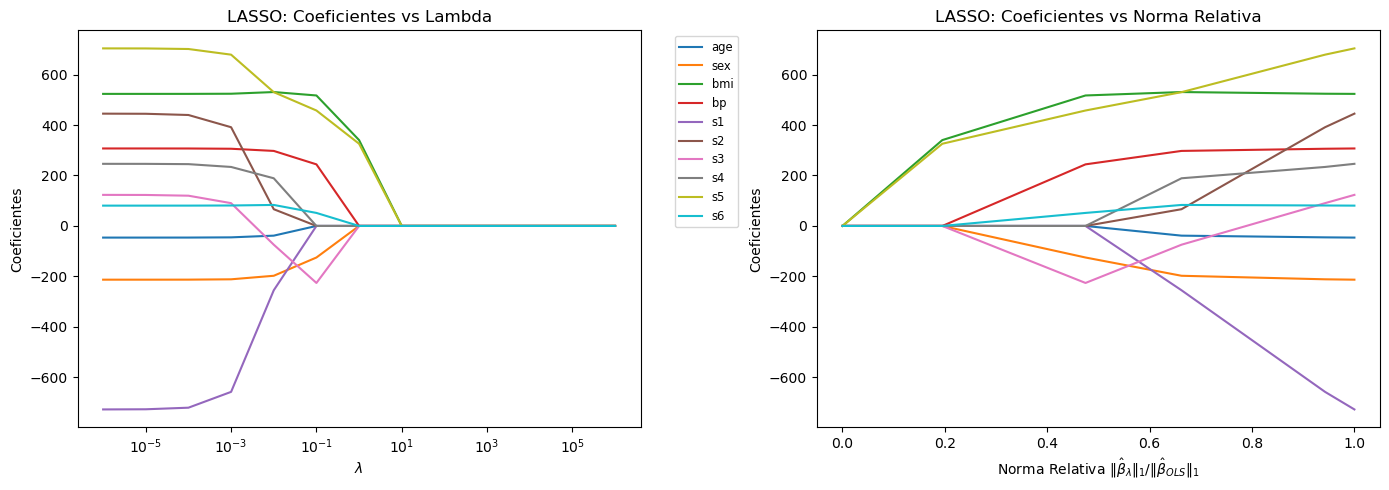

In [41]:
# Entrenar modelo OLS (alpha = 0)
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_coef = ols.coef_
ols_coef_norm = np.linalg.norm(ols_coef, ord=1)

# Entrenar modelos para cada alpha para visualización
coefs = []

for alpha in lambdas:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)

coefs = np.array(coefs)

# Calcular norma relativa con respecto a la solución OLS (norma 1)
norms = np.linalg.norm(coefs, ord=1, axis=1)
relative_norms = norms / ols_coef_norm

# Crear las gráficas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Izquierda: Coeficientes vs lambda
for i in range(X_train.shape[1]):
    axes[0].plot(lambdas, coefs[:, i], label=X_train.columns[i])
axes[0].set_xscale('log')
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('Coeficientes')
axes[0].set_title('LASSO: Coeficientes vs Lambda')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Derecha: Coeficientes vs norma relativa
for i in range(X_train.shape[1]):
    axes[1].plot(relative_norms, coefs[:, i], label=X_train.columns[i])
axes[1].set_xlabel(r'Norma Relativa $\|\hat{\beta}_\lambda\|_1 / \|\hat{\beta}_{OLS}\|_1$')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('LASSO: Coeficientes vs Norma Relativa')

plt.tight_layout()
plt.show()


### ElasticNet

ElasticNet es un modelo de regresión lineal regularizada que combina las penalizaciones de Lasso (L1) y Ridge (L2).

Es ideal cuando:
- Hay muchas variables predictoras.
- Existe multicolinealidad entre las variables.
- Se quiere un equilibrio entre selección de variables y estabilidad del modelo.

Minimiza:

$\text{RSS} + \alpha \left( \lambda \sum | \beta_j | + (1 - \lambda) \sum \beta_j^2 \right)$

Donde:
- RSS: Suma de errores cuadrados.
- $\alpha$ (alpha): Controla la fuerza de la regularización.
- $\lambda$ (l1_ratio): Controla la proporción entre Lasso (L1) y Ridge (L2).

  - l1_ratio = 1 → Lasso puro.
  - l1_ratio = 0 → Ridge puro.


#####  Ventajas del ElasticNet

- Selecciona automáticamente variables relevantes (como Lasso).
- Reduce la varianza y mejora la estabilidad en presencia de multicolinealidad (como Ridge).
- Útil cuando:
  - Hay más variables que observaciones.
  - Lasso por sí solo elimina demasiadas variables importantes.
  - Las variables están correlacionadas entre sí.


##### Implementación en scikit-learn

- ElasticNet: Ajuste manual de alpha y l1_ratio.
- ElasticNetCV: Selección automática de los mejores hiperparámetros mediante validación cruzada.

In [42]:
# Ajustar el modelo ElasticNet con valores específicos de alpha y l1_ratio
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5, max_iter=10000)
elastic_net.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_net.coef_
})

# Añadir columna para los coeficientes en valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del ElasticNet")
print(coef_df)


Coeficientes del ElasticNet
  Feature  Coefficient  Abs_Coefficient
8      s5     3.099037         3.099037
2     bmi     3.010161         3.010161
7      s4     2.346129         2.346129
6      s3    -2.040421         2.040421
3      bp     1.969172         1.969172
9      s6     1.847214         1.847214
4      s1     0.611880         0.611880
5      s2     0.443049         0.443049
0     age     0.186116         0.186116
1     sex     0.000000         0.000000


Si no especificamos los parámteros alpha y l1_ratio en ElasticNetCV(), los parámetros alpha son escogidos al igual que en LassoCV(), mientras que el l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1].

In [43]:
# Ajustar modelo ElasticNetCV con validación cruzada
elastic_cv = ElasticNetCV(cv=5, max_iter=10000)
elastic_cv.fit(X_train, y_train)

# Mostrar el mejor alpha y l1_ratio encontrados
print(f"Mejor alpha encontrado (Elastic Net): {elastic_cv.alpha_}")
print(f"Mejor l1_ratio encontrado (Elastic Net): {elastic_cv.l1_ratio_:.2f}")

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (ElasticNet):")
print(coef_df.head(10))  # Top 10 características más relevantes

# Hacer predicciones en los datos de entrenamiento
y_pred = elastic_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Obtener el MSE promedio por alpha para el mejor l1_ratio encontrado
cv_mse = np.mean(elastic_cv.mse_path_, axis=1)  # promedio sobre las folds

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Alpha (lambda)': elastic_cv.alphas_,
    'Mean Val Score (MSE)': cv_mse
})

# Agregar ranking de MSE
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar por ranking
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar resultados
print(f"Mejor combinación encontrada: alpha = {elastic_cv.alpha_}, l1_ratio = {elastic_cv.l1_ratio_}")
print("\nResultados por alpha para el mejor l1_ratio:")
results_df

Mejor alpha encontrado (Elastic Net): 0.004139157400766346
Mejor l1_ratio encontrado (Elastic Net): 0.50

Coeficientes del mejor modelo (ElasticNet):
  Feature  Coefficient  Abs_Coefficient
2     bmi   305.558537       305.558537
8      s5   263.126161       263.126161
3      bp   188.345164       188.345164
6      s3  -156.823447       156.823447
7      s4   137.033206       137.033206
9      s6   125.330255       125.330255
1     sex   -73.613622        73.613622
4      s1    17.546112        17.546112
5      s2   -11.282796        11.282796
0     age     7.971627         7.971627

MSE en entrenamiento: 3207.5806
R² en entrenamiento: 0.4514
Mejor combinación encontrada: alpha = 0.004139157400766346, l1_ratio = 0.5

Resultados por alpha para el mejor l1_ratio:


,Alpha (lambda),Mean Val Score (MSE),Rank Val Score
99,0.004139,3307.946196,1.0
98,0.004438,3331.352623,2.0
97,0.004759,3356.306032,3.0
96,0.005103,3382.723482,4.0
95,0.005472,3410.638544,5.0
...,...,...,...
4,3.131121,5850.961503,96.0
3,3.357398,5851.883471,97.0
2,3.600028,5852.587667,98.0
1,3.860192,5853.131005,99.0


In [44]:
# Definir el grid de valores para alpha (lambda) y l1_ratio (mezcla entre LASSO y Ridge)
lambdas=np.logspace(-3, 3, 7)
param_grid = {
    'alpha': lambdas,
    'l1_ratio': np.append(0.01, np.linspace(0.1, 1.0, 19))  # 0 es Ridge, 1 es LASSO
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#Validacion cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=100)

# Configurar el GridSearchCV con ElasticNet
grid_search = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_grid,
    cv=cv, 
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto de entrenamiento y validación
grid_search.fit(X_train, y_train)

# Ver el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar rendimiento en entrenamiento
y_pred = best_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame para mostrar los resultados de manera ordenada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'L1 Ratio': results['param_l1_ratio'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de la prueba (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo ElasticNet
coefficients = best_model.coef_

# Crear un DataFrame para mostrar los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Si X_train es un DataFrame con nombres de columna
    'Coefficient': coefficients
})

# Ordenar los coeficientes por valor absoluto para ver cuáles tienen mayor impacto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"Coeficientes del mejor modelo: {best_model}")
print(coef_df)

print("Resultados de la búsqueda con validación cruzada (Elastic Net)):")
results_df


MSE en entrenamiento: 2899.7421
R² en entrenamiento: 0.5040
Coeficientes del mejor modelo: ElasticNet(alpha=0.001, l1_ratio=0.8)
  Feature  Coefficient  Abs_Coefficient
2     bmi   492.815805       492.815805
8      s5   429.198560       429.198560
3      bp   282.419540       282.419540
1     sex  -181.335168       181.335168
6      s3  -165.793657       165.793657
7      s4   155.356078       155.356078
9      s6   105.550637       105.550637
4      s1   -67.055244        67.055244
5      s2   -50.686033        50.686033
0     age   -34.076689        34.076689
Resultados de la búsqueda con validación cruzada (Elastic Net)):


,Alpha (lambda),L1 Ratio,Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
15,0.001,0.8,3041.861271,474.662423,2882.121368,111.671528,1
16,0.001,0.85,3042.154570,469.972446,2877.218342,111.628628,2
14,0.001,0.75,3042.561702,478.794267,2887.482718,111.810928,3
17,0.001,0.9,3044.059152,465.109313,2872.337549,111.950638,4
13,0.001,0.7,3044.181445,482.425222,2893.260955,112.046614,5
...,...,...,...,...,...,...,...
107,100.0,0.4,5927.898230,761.018030,5837.080953,181.881404,86
108,100.0,0.45,5927.898230,761.018030,5837.080953,181.881404,86
109,100.0,0.5,5927.898230,761.018030,5837.080953,181.881404,86
111,100.0,0.6,5927.898230,761.018030,5837.080953,181.881404,86


### LASSOLAR

In [45]:
# Ajustar el modelo LAR con un valor específico de alpha
lar = LassoLars(alpha=0.1)
lar.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df_lar = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lar.coef_
})

# Añadir columna con los valores absolutos
coef_df_lar['Abs_Coefficient'] = coef_df_lar['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df_lar = coef_df_lar.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del modelo LASSO LAR")
print(coef_df_lar)



Coeficientes del modelo LASSO LAR
  Feature  Coefficient  Abs_Coefficient
2     bmi   517.079642       517.079642
8      s5   457.447260       457.447260
3      bp   244.075975       244.075975
6      s3  -225.863062       225.863062
1     sex  -125.019844       125.019844
9      s6    51.635270        51.635270
0     age     0.000000         0.000000
4      s1     0.000000         0.000000
5      s2     0.000000         0.000000
7      s4     0.000000         0.000000


In [46]:
# Ajustar el modelo LassoLarsCV con validación cruzada
lar_cv = LassoLarsCV(cv=5, max_iter=10000)
lar_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"Mejor alpha encontrado: {lar_cv.alpha_}")

# Crear un DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lar_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (LAR):")
print(coef_df.head(10))  # Top 10 características más relevantes

# Hacer predicciones en los datos de entrenamiento
y_pred = lar_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

Mejor alpha encontrado: 0.0

Coeficientes del mejor modelo (LAR):
  Feature  Coefficient  Abs_Coefficient
4      s1  -727.106693       727.106693
8      s5   703.645018       703.645018
2     bmi   523.335899       523.335899
5      s2   445.050491       445.050491
3      bp   307.062259       307.062259
7      s4   246.186567       246.186567
1     sex  -212.879797       212.879797
6      s3   123.165998       123.165998
9      s6    80.538374        80.538374
0     age   -46.103647        46.103647

MSE en entrenamiento: 2873.7577
R² en entrenamiento: 0.5085


In [47]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)  # Diferentes valores de alpha
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con LassoLars
grid_search = GridSearchCV(
    estimator=LassoLars(max_iter=10000),  # Aumentamos max_iter para evitar warnings de convergencia
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto combinado (ya escalado)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame con los resultados de la validación cruzada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de validación (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo LAR
coefficients = best_model.coef_

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Ordenar los coeficientes por su valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo LASSO LAR (alpha = {best_model.alpha}):")
print(coef_df)

print("\nResultados de la búsqueda con validación cruzada (Lasso LAR):")
results_df


Coeficientes del mejor modelo LASSO LAR (alpha = 1e-06):
  Feature  Coefficient  Abs_Coefficient
4      s1  -727.037516       727.037516
8      s5   703.620308       703.620308
2     bmi   523.336481       523.336481
5      s2   444.997055       444.997055
3      bp   307.061120       307.061120
7      s4   246.174244       246.174244
1     sex  -212.878330       212.878330
6      s3   123.133425       123.133425
9      s6    80.538925        80.538925
0     age   -46.102722        46.102722

Resultados de la búsqueda con validación cruzada (Lasso LAR):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
0,0.000001,3065.281798,275.394198,2853.301767,56.472591,1
1,0.00001,3065.282166,275.379218,2853.301787,56.472590,2
2,0.0001,3065.288102,275.230465,2853.303762,56.472490,3
3,0.001,3065.573539,273.849302,2853.501300,56.462441,4
4,0.01,3072.108496,262.793845,2861.887051,57.528636,5
5,0.1,3087.693926,222.019372,2910.955768,54.907809,6
6,1.0,3939.542488,583.233307,3791.243594,57.173312,7
7,10.0,5853.579820,1018.696580,5845.395912,254.947897,8
8,100.0,5853.579820,1018.696580,5845.395912,254.947897,8
9,1000.0,5853.579820,1018.696580,5845.395912,254.947897,8


### Incremental Forward Stagewise Regression

### Selector de Dantzig
Aunque no existen implementaciones estándar del Selector de Dantzig en bibliotecas comunes de Python como scikit-learn, es posible resolver este problema utilizando bibliotecas de optimización convexa como cvxpy.

### Grouped LASSO

In [48]:
# Suponiendo que X_train_scaled y y_train ya están definidos

groups = np.array([0]*4 + [1]*6)

# Inicializar el modelo Group Lasso
model = GroupLasso(
    groups=groups,
    group_reg=0.1,  # Regularización a nivel de grupo
    l1_reg=0.01,    # Regularización L1 individual
    scale_reg='group_size',  # Escalar la regularización según el tamaño del grupo
    subsampling_scheme=1,
    supress_warning=True,
    fit_intercept=True
)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Obtener los coeficientes estimados
coeficientes = model.coef_

# Asegurarse de que los coeficientes sean unidimensionales
coeficientes = coeficientes.flatten()

# Crear un DataFrame para visualizar los coeficientes
coef_df = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': coeficientes
})

# Ordenar por el valor absoluto de los coeficientes
coef_df['Valor absoluto'] = coef_df['Coeficiente'].abs()
coef_df = coef_df.sort_values(by='Valor absoluto', ascending=False)

print(coef_df)


  Característica  Coeficiente  Valor absoluto
8             s5     2.555102        2.555102
2            bmi     2.447090        2.447090
7             s4     2.083980        2.083980
6             s3    -1.890356        1.890356
3             bp     1.806416        1.806416
9             s6     1.768524        1.768524
4             s1     0.992010        0.992010
5             s2     0.886579        0.886579
0            age     0.708289        0.708289
1            sex     0.256356        0.256356


c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\group_lasso\_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


# Reducción de Dimensión

### Regresión de Componentes Principales

PCA es sensible a la escala de los datos, por lo tanto, es recomendable escalar antes de aplicar PCA.

In [49]:
# Aplicamos PCA
pca = PCA()
X_pca = pca.fit_transform(X_train)

# Varianza explicada por componente
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Mostrar en tabla con pandas
tabla_varianza = pd.DataFrame({
    "Componente": [f"PC{i+1}" for i in range(len(explained_var))],
    "Varianza Explicada Individual": explained_var,
    "Varianza Explicada Acumulada": cum_var
})

tabla_varianza

,Componente,Varianza Explicada Individual,Varianza Explicada Acumulada
0,PC1,0.400513,0.400513
1,PC2,0.157203,0.557716
2,PC3,0.110723,0.668438
3,PC4,0.095165,0.763603
4,PC5,0.067921,0.831525
5,PC6,0.062701,0.894225
6,PC7,0.052601,0.946826
7,PC8,0.043813,0.990639
8,PC9,0.008459,0.999098
9,PC10,0.000902,1.000000


In [50]:
cargas = pd.DataFrame(pca.components_.T, 
                      columns=[f"PC{i+1}" for i in range(X.shape[1])],
                      index=X.columns)

print("Cargas de los componentes principales (phi_jm):")
cargas.round(4)

Cargas de los componentes principales (phi_jm):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
age,0.2292,0.3384,0.3519,-0.3042,-0.7680,-0.1323,0.0741,0.0609,-0.0012,0.0014
sex,0.1958,-0.3648,0.0499,-0.7419,0.2227,0.0599,-0.1682,0.4402,0.0157,0.0098
bmi,0.2870,-0.1227,0.2107,0.4599,-0.1551,0.6103,-0.2892,0.4046,0.0521,0.0113
bp,0.2778,0.0466,0.5581,-0.1149,0.3574,0.3365,0.4408,-0.4004,0.0165,-0.0055
s1,0.3187,0.4970,-0.2992,-0.0494,0.1951,0.0661,0.0060,0.1010,-0.0368,0.7109
s2,0.3295,0.3013,-0.4184,-0.1622,0.0221,0.2791,-0.1681,-0.2108,-0.3591,-0.5650
s3,-0.3062,0.5974,0.1621,-0.0719,0.2767,0.0493,-0.1147,0.2904,0.4939,-0.3123
s4,0.4308,-0.1950,-0.3348,0.0231,-0.1161,-0.0565,0.1112,-0.1928,0.7674,-0.0928
s5,0.3944,0.0390,0.0307,0.2906,0.1913,-0.4583,0.4201,0.4816,-0.1834,-0.2624
s6,0.3232,0.0310,0.3375,0.1160,0.2087,-0.4419,-0.6767,-0.2652,0.0019,0.0108


In [51]:
# Elegimos, por ejemplo, los primeros 4 componentes
n_components = 4
X_reduced = X_pca[:, :n_components]

# Modelo de regresión de componentes principales
modelo = LinearRegression()
modelo.fit(X_reduced, y_train)

# Evaluamos con validación cruzada
scores = cross_val_score(modelo, X_reduced, y_train, cv=5, scoring='r2')

print(f"R^2 promedio con PCR usando {n_components} componentes:", np.mean(scores))

R^2 promedio con PCR usando 4 componentes: 0.45203486133116744


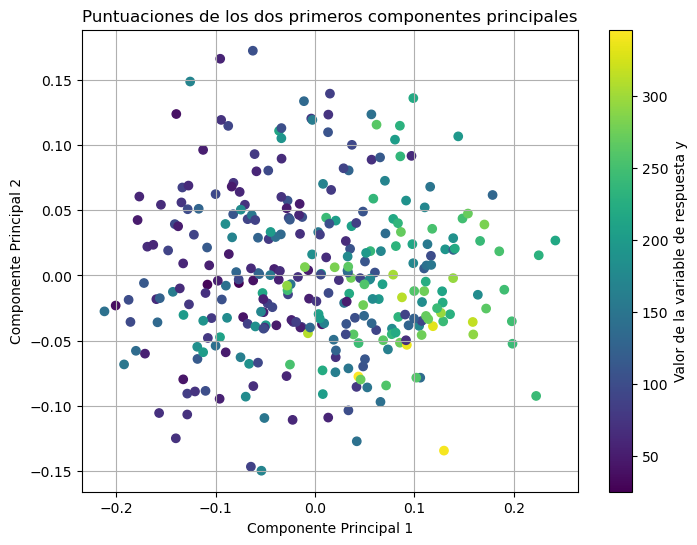

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Puntuaciones de los dos primeros componentes principales")
plt.colorbar(label='Valor de la variable de respuesta y')
plt.grid(True)
plt.show()

Número óptimo de componentes para explicar 95% de la varianza: 8


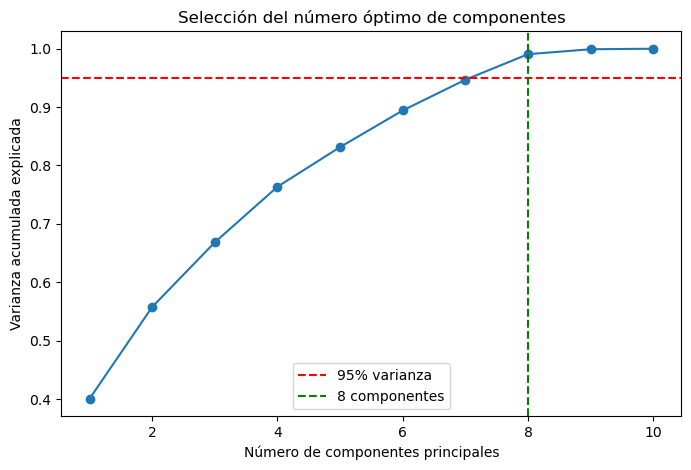

Coeficientes (PCR): [ 21.72257665 -10.53467937  13.89722882  24.73298745   1.83648429
   5.48867744   9.99333337   5.67537887]
[ 470.11289929 -159.62075657  272.43861526  551.68418798   41.41966731
  126.33133224  191.56843684  130.86414015]
R^2 promedio con PCR usando 8 componentes: 0.456673992478594


In [53]:
# PCA completo
pca = PCA()
X_pca = pca.fit_transform(X_train)
explained_var = pca.explained_variance_ratio_

# Varianza acumulada
cum_var = np.cumsum(explained_var)

# Encontrar el mínimo número de componentes que explica al menos 95%
threshold = 0.95
n_components_optimo = np.argmax(cum_var >= threshold) + 1

# Mostrar
print(f"Número óptimo de componentes para explicar {threshold*100:.0f}% de la varianza: {n_components_optimo}")

# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold*100)}% varianza')
plt.axvline(x=n_components_optimo, color='g', linestyle='--', label=f'{n_components_optimo} componentes')
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza acumulada explicada")
plt.title("Selección del número óptimo de componentes")
plt.legend()
plt.show()

# Entrenar modelo final con ese número de componentes óptimos
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_components_optimo)),
    ("reg", LinearRegression())
])
final_model.fit(X_train, y_train)

# Mostrar coeficientes (en espacio de componentes principales)
pca_step = final_model.named_steps['pca']
reg_step = final_model.named_steps['reg']
print("Coeficientes (PCR):", reg_step.coef_)

X_reduced = X_pca[:, :n_components_optimo]

# Modelo de regresión
modelo = LinearRegression()
modelo_final=modelo.fit(X_reduced, y_train).coef_
print(modelo_final)

# Evaluamos con validación cruzada
scores = cross_val_score(modelo, X_reduced, y_train, cv=5, scoring='r2')

print(f"R^2 promedio con PCR usando {n_components_optimo} componentes:", np.mean(scores))

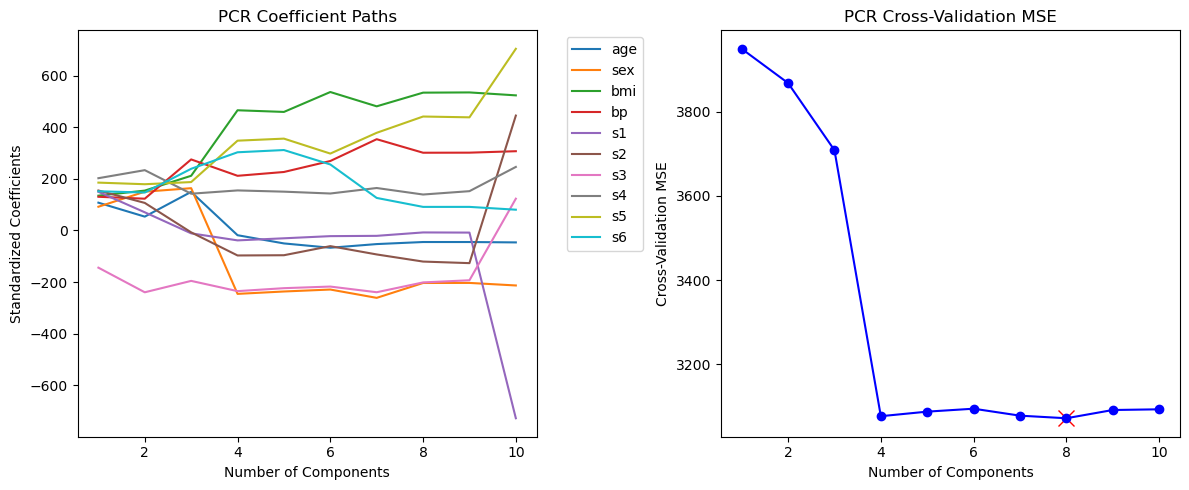

In [54]:
# Cargar nombres de las variables del dataset de diabetes
feature_names = load_diabetes().feature_names

n_components = X_train.shape[1]
coefs = np.zeros((n_components, n_components))
mse_cv = []

for m in range(1, n_components + 1):
    # PCA con m componentes
    pca = PCA(n_components=m)
    X_train_pca = pca.fit_transform(X_train)

    # Ajustar regresión
    model = LinearRegression()
    model.fit(X_train_pca, y_train)

    # Proyectar coeficientes al espacio original
    beta_original = np.dot(pca.components_.T, model.coef_)
    coefs[m - 1, :] = beta_original

    # Calcular MSE con validación cruzada (usando X_train_pca y y_train)
    mse = -cross_val_score(model, X_train_pca, y_train, cv=10, scoring='neg_mean_squared_error').mean()
    mse_cv.append(mse)

# Gráficas
plt.figure(figsize=(12, 5))

# Coeficientes
plt.subplot(1, 2, 1)
for i in range(n_components):
    plt.plot(range(1, n_components + 1), coefs[:, i], label=feature_names[i])
plt.xlabel('Number of Components')
plt.ylabel('Standardized Coefficients')
plt.title('PCR Coefficient Paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# MSE
plt.subplot(1, 2, 2)
min_index = np.argmin(mse_cv)  # índice del menor MSE
plt.plot(min_index + 1, mse_cv[min_index], 'rx', markersize=12, label='Mínimo MSE')
plt.plot(range(1, n_components + 1), mse_cv, '-o', color='blue')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation MSE')
plt.title('PCR Cross-Validation MSE')

plt.tight_layout()
plt.show()

Número óptimo de componentes: 8
Coeficientes (PCR): [ 21.31845198 -12.2123018   11.33198401  28.21105533  -0.79350747
  -8.56907107   7.45930342   3.64855022]


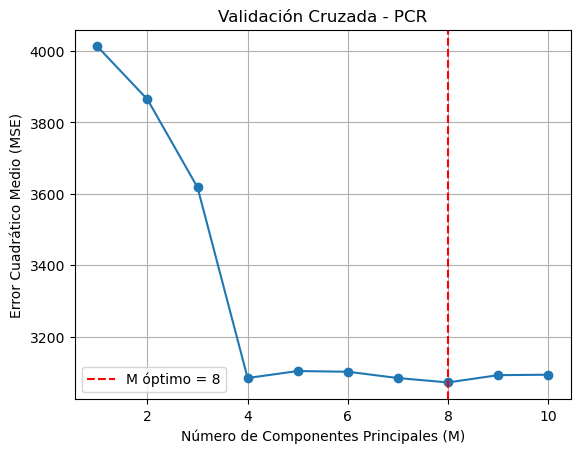

In [55]:
# Crear listas para almacenar errores
mse_list = []
components_range = range(1, X.shape[1] + 1)

# Evaluar diferentes números de componentes (PCR)
for m in components_range:
    # Crear pipeline: estandarizar -> PCA -> regresión
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=m)),
        ("reg", LinearRegression())
    ])
    
    # Validación cruzada (neg_mean_squared_error → cambiar signo)
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    mse = -scores.mean()
    mse_list.append(mse)

# Encontrar el número óptimo de componentes
optimal_m = np.argmin(mse_list) + 1
print(f"Número óptimo de componentes: {optimal_m}")

# Entrenar modelo final con ese M
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=optimal_m)),
    ("reg", LinearRegression())
])
final_model.fit(X, y)

# Mostrar coeficientes (en espacio de componentes principales)
pca_step = final_model.named_steps['pca']
reg_step = final_model.named_steps['reg']
print("Coeficientes (PCR):", reg_step.coef_)

# Gráfica del error en función del número de componentes
plt.plot(components_range, mse_list, marker="o")
plt.axvline(optimal_m, color="r", linestyle="--", label=f"M óptimo = {optimal_m}")
plt.xlabel("Número de Componentes Principales (M)")
plt.ylabel("Error Cuadrático Medio (MSE)")
plt.title("Validación Cruzada - PCR")
plt.legend()
plt.grid(True)
plt.show()


### PLS

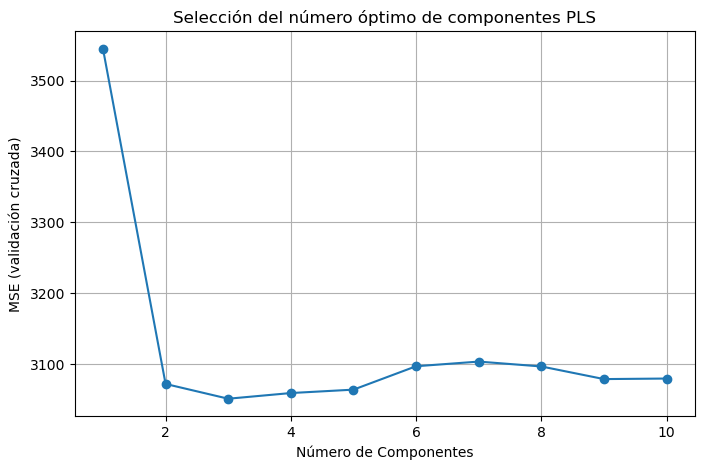

Componentes óptimos: 3
R2 (train): 0.504
RMSE (train): 53.842


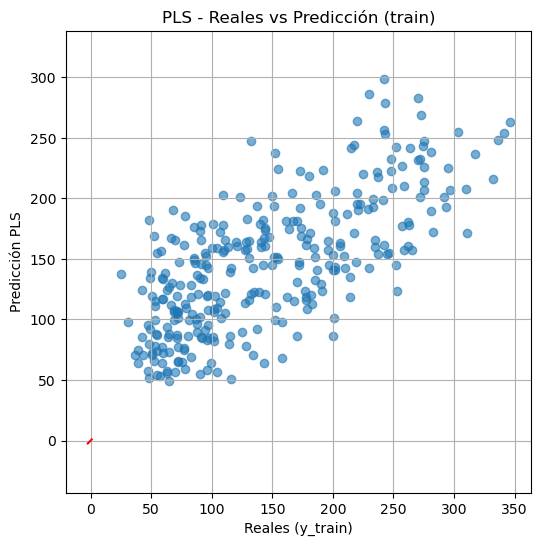

AttributeError: 'DataFrame' object has no attribute 'feature_names'

<Figure size 1000x600 with 0 Axes>

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Asumimos que X_train, y_train ya están estandarizados

# 1. Evaluar componentes con CV
max_components = X_train.shape[1]
mse_cv = []

for n in range(1, max_components + 1):
    pls = PLSRegression(n_components=n)
    neg_mse = cross_val_score(pls, X_train, y_train, cv=KFold(10, shuffle=True, random_state=42),
                              scoring='neg_mean_squared_error')
    mse_cv.append(-neg_mse.mean())

# 2. Graficar MSE CV vs componentes
plt.figure(figsize=(8,5))
plt.plot(range(1, max_components + 1), mse_cv, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('MSE (validación cruzada)')
plt.title('Selección del número óptimo de componentes PLS')
plt.grid(True)
plt.show()

# 3. Entrenar modelo con número óptimo de componentes
optimal_n = np.argmin(mse_cv) + 1
pls_final = PLSRegression(n_components=optimal_n)
pls_final.fit(X_train, y_train)
y_pred_train = pls_final.predict(X_train)

# 4. Métricas sobre train
print(f"Componentes óptimos: {optimal_n}")
print(f"R2 (train): {r2_score(y_train, y_pred_train):.3f}")
print(f"RMSE (train): {np.sqrt(mean_squared_error(y_train, y_pred_train)):.3f}")

# 5. Pred vs real
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_pred_train, alpha=0.6)
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("Reales (y_train)")
plt.ylabel("Predicción PLS")
plt.title("PLS - Reales vs Predicción (train)")
plt.axis('equal')
plt.grid(True)
plt.show()

# 6. Pesos de las variables
weights = pls_final.x_weights_
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(weights, index=data.feature_names, columns=[f"Comp{i+1}" for i in range(optimal_n)]),
            annot=True, cmap='coolwarm')
plt.title("Pesos de las variables en cada componente")
plt.show()

# 7. Biplot si hay al menos 2 componentes
if optimal_n >= 2:
    T = pls_final.transform(X_train)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(T[:,0], T[:,1], c=y_train, cmap='coolwarm', alpha=0.7)
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.title("Biplot PLS (espacio latente)")
    plt.colorbar(scatter, label='y_train')
    plt.grid(True)
    plt.show()
